In [1]:
%load_ext pycodestyle_magic
%flake8_on
# la convention PEP8 est ainsi testée

# 1. Objectifs du projet

Nous cherchons à exploiter pour le compte d'Olist (solution de ventre sur les marketplaces en ligne), un historique de commande, afin de fournir aux équipes marketing une proposition de segmentation client. <br/>
<br/>
Le but est de :
- fournir une description de cette segmentation client dont l'équipe marketing pourra déduire des actions, 
- expliciter la logique sous-jacente, 
- vérifier les conditions de stabilité dans le temps des segments proposés et proposition de contrat de maintenance. <br/>
<br/>
Le présent notebook détaille l'ensemble des étapes d'analyse des données et de construction (en créant des features dérivés), d'un dataset centré clients assortis de découpages temporels, en vue de réaliser des segmentations et tester leur stabilité.

# 2. Structure des données

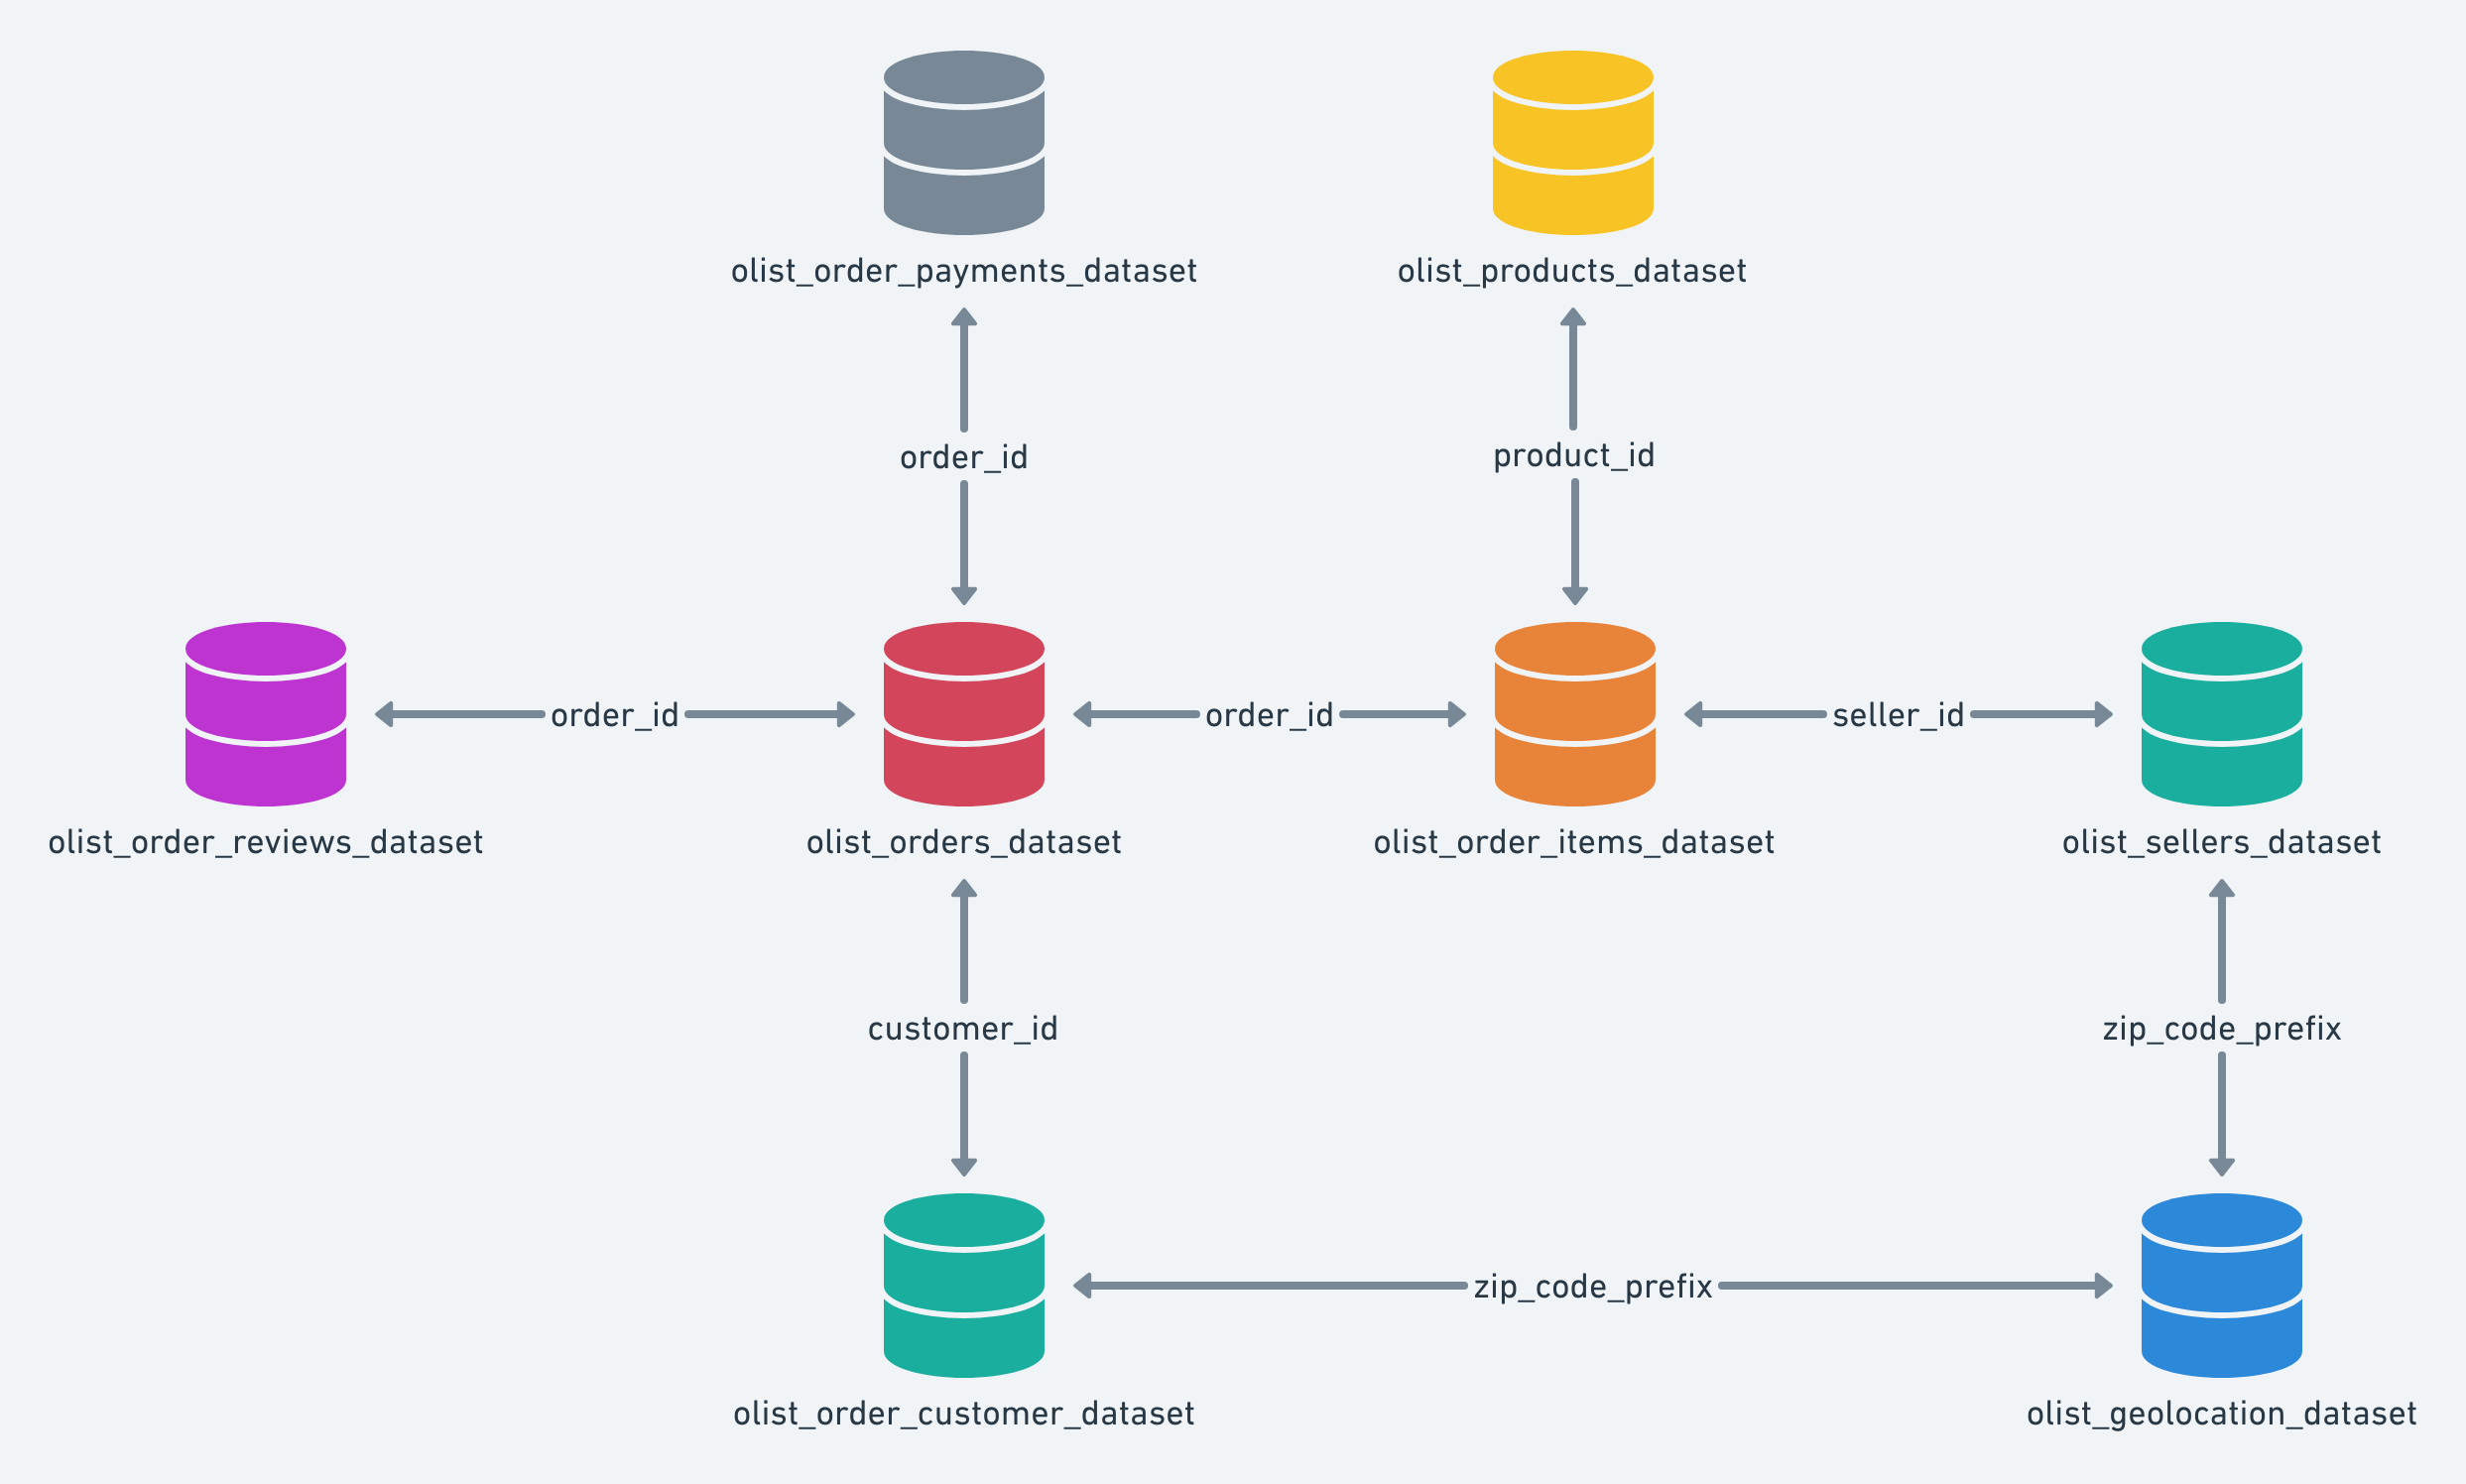

source {fig, datasets} : https://www.kaggle.com/olistbr/brazilian-ecommerce

Olist a mis a disposition les données sur Kaggle : y sont décrits les 8 datasets ainsi qu'un fichier product_category_name_translation. <br/>
Le schéma ci-dessus présente les datasets reliés par les clés indiquées.<br/>

En termes de cardinalités :
- les datasets sont fusionnables simplement avec une cardinalité 1:1 : cas de l'order_id depuis l'orders_dataset, mais également : customer_id, seller_id et product_id,
- un order est composé d'une liste de produits (1:n) via la notion d'items dans le datasets identifiant aussi le seller (1:1).
- un customerunique_id regroupe tous les customer_id associés en 1:1 à un order_id,
- le geolocation_dataset est associé via un zip_code_prefix, soit à un customer, soit à un seller. <br/>

Hors schéma, il reste une association simple des product_category_name en anglais qu'on exploitera pour une meilleure lisibilité.

In [222]:
# importer les packages
# common
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
# specific
from datetime import datetime
import time
# paramètres
sns.set(style="ticks")

In [3]:
# créer les dataframes correspondants aux données
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_translation = pd.read_csv('Data/product_category_name_translation.csv')

In [4]:
# créer le dict des datasets
datasets = {
    'Orders': df_orders,
    'Items': df_items,
    'Customers': df_customers,
    'Payments': df_payments,
    'Products': df_products,
    'Sellers': df_sellers,
    'Reviews': df_reviews,
    'Geolocation': df_geolocation,
    'Translation': df_translation,
}

In [5]:
# observer les tailles des datasets
for x, y in datasets.items():
    print(f'{x} shape is : ' f'{list(y.shape)}')

Orders shape is : [99441, 8]
Items shape is : [112650, 7]
Customers shape is : [99441, 5]
Payments shape is : [103886, 5]
Products shape is : [32951, 9]
Sellers shape is : [3095, 4]
Reviews shape is : [100000, 7]
Geolocation shape is : [1000163, 5]
Translation shape is : [71, 2]


Les données de 100 000 Commandes environ ont été mises à disposition.

In [6]:
# observer les valeurs manquantes
# for x, y in datasets.items():
#    print(f'{x} nan values : \n' f'{y.isna().sum()}')

In [7]:
# fonction d'affichage de la distribution d'un feature

def distribution(df, feature, xlbl):
    plt.figure(figsize=(11, 4))
    x = df.loc[~df[feature].isnull(),
               feature]
    x = np.array(x)
    sns.set(style='whitegrid')
    sns.boxplot(data=x, orient='h')
    plt.title('Distribution of {}'.format(feature))
    plt.xlabel(xlbl)
    plt.yticks([])
    plt.show()



In [8]:
# fonction de split en catégories

def cuts(feature):
    limits = []
    lim_min = feature.min()
    lim_max = feature.max()
    upper_quartile = np.percentile(feature, 75)
    lower_quartile = np.percentile(feature, 25)
    iqr = upper_quartile - lower_quartile
    upper_whisker = feature[feature <= upper_quartile+1.5*iqr].max()
    lower_whisker = feature[feature >= lower_quartile-1.5*iqr].min()
    limits = [lim_min-0.01,
              lower_whisker-0.01,
              lower_quartile-0.01,
              upper_quartile+0.01,
              upper_whisker+0.01,
              lim_max+0.01]
    return(limits)



In [9]:
ref = df_orders.shape[0]

# 3. Pertinence du recentrage sur le Client
Au vu du but recherché le principe est de construire des features caractérisant le Client, i.e. d'aggréger des données synthétiques au Customer_unique_id.<br/>
Dans cette logique, il faut opérer la sélection et le traitement des informations à "remonter" vers le Client au fil des liens d'association et cardinalité successifs.<br/>
Nous allons d'abord observer le triptyque Commande - Article - Client et son "recentrage" sur le Client.

## 3.1. Aperçu des données Clients

In [10]:
# aperçu des données customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
9362,d5953c17ff6eb3e890cc06072c6894e2,b7939839a65fa5d44768ed0140e6c4eb,15440,nova granada,SP
49297,5f4228ef54e408563a162a0a80e932d4,a3c7ff0f0ea89336b1c0f0587bdb3a38,12380,santa branca,SP
15509,031bfdd243a35f3b665ed9833e01629d,ec2e5aafb6e1a4832c297bfa2b9433aa,4138,sao paulo,SP


In [11]:
# compter le nombre de clients
df_customers['customer_unique_id'].unique().size

96096

Les données sont anonymisées et sommaires : la localisation {ville, état} reliée à une {lat, lng} via un code, ainsi que le customer_unique_id qui  regroupe tous les customer_id eux-mêmes reliés aux order_id. 

In [12]:
# compter le nb d'achat par client
df_customers_purchase = df_customers.groupby(
    'customer_unique_id',
    as_index=False).agg({'customer_id': ['count']})
df_customers_purchase.columns = ['customer_unique_id',
                                 'order_count']

In [13]:
# afficher les 10 clients ayant effectué le plus de commandes
df_customers_purchase = df_customers_purchase.sort_values(by='order_count',
                                                          ascending=False)
df_customers_purchase[:10]

,customer_unique_id,order_count
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
7175,12f5d6e1cbf93dafd9dcc19095df0b3d,6
83540,de34b16117594161a6a89c50b289d35a,6
37585,63cfc61cee11cbe306bff5857d00bfe4,6
90451,f0e310a6839dce9de1638e0fe5ab282a,6
27043,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


In [14]:
# moyenne des commandes par client
df_customers_purchase['order_count'].mean()

1.0348089410589412

In [15]:
# nombre de clients pour lesquels on détient l'information de 2 achats ou plus
df_customers_purchase[df_customers_purchase['order_count'] > 1].shape

(2997, 2)

In [16]:
# pourcentage des clients multi-acheteurs
print(round(100 *
            df_customers_purchase[df_customers_purchase['order_count'] >
                                  1].shape[0] /
            df_customers_purchase.shape[0], 2)) 

3.12


In [17]:
# aggréger le nb d'achats effectués pour chaque client unique
df_customers = df_customers.merge(
    df_customers_purchase,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

In [18]:
# observer le résultat
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
50409,ee36e794ec0c9542a84dce88f1a05b9c,4dbdde6e1e0a6931a1872f33d61b541d,9132,santo andre,SP,1
97994,0c8f1fe40f0c95b4950b37803c3ca0ad,df486f450c1381f138211159ea8c650b,72885,cidade ocidental,GO,1
8827,a70354351603c255327b5159c9c3b5ec,a559ec236e83919624a319c364dbee39,28300,itaperuna,RJ,1


## 3.2. Limitation des données
Nous constatons seulement 3 % d'acheteurs récurrents dans les données mises à disposition. <br/>
L'application de la méthode de segmentation RFM (Récence, Fréquence, Montant) est très largement compromise par cette troncature des données. 
En effet, en termes de segmentation, si des commandes ont été retirées pour la majorité des clients on retrouvera logiquement un groupe de clients étant fictivement les seuls à avoir réalisé plusieurs achats (Fréquence). <br/>
Par ailleurs, l'analyse de l'intervalle entre 2 achats risque de ne pas être représentative au moins quantitativement (Fréquence). <br/>
Enfin, le découpage dans le temps sans données longitudinales rend caduque la notion d'ancienneté client (Récence). <br/>

## 3.3. Aggrégation sur la Commande
Nous nous efforcerons donc de produire pour le marketing une caractéristation "directe" d'un nouveau client, en limitant autant que possible le biais d'une nouvelle troncature de donnée, selon la façon de retenir une commande unique par client (ex. la dernière commande effectuée, le produit le plus cher, etc.). <br/>

In [19]:
# contrôler les données manquantes
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

# 4. La Commande au centre des données

In [20]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


La Commande est bien le centre initial et privilégié des données : elle permet de remonter aux Produits et aux Vendeurs via la notion d'Article (Item, qui représente le panier acheté). Elle est reliée directement aux Clients, aux Paiements et aux Avis. <br/>
Le processus pour chaque commande est détaillé (order_status et dates associées), à commencer par la date et l'heure d'achat. <br/>
Ces données temporelles permettent d'appréhender la période couverte et d'étudier la stabilité de la segmentation. <br/>
Nous passons en revue les éléments de la commande et des données reliées, susceptibles de caractériser le Client.

## 4.1. Order Status : filtrer les Commandes échues

In [21]:
# lister les valeurs possibles de l'order_status
df_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Text(0.5, 1.02, 'Order Status')

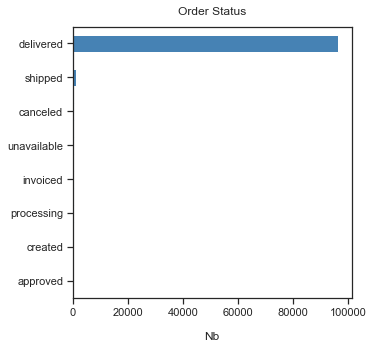

In [22]:
# observer la répartition des commandes par status
df_orders['order_status'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.title('Order Status', y=1.02)

On choisit de retirer les commandes "en cours" et retirer les commandes non disponibles ou annulées (qui peuvent faire l'objet d'une attention client spécifique).

In [23]:
# retirer les commandes en cours
df_orders = df_orders[df_orders['order_status'] == 'delivered']
print(df_orders.shape)

(96478, 8)


In [24]:
# détecter les valeurs manquantes
df_orders.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [25]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(96455, 8)


In [26]:
print(ref-df_orders.shape[0])

2986


## 4.2. Order process : exploiter les dates de Commande
Le processus de commande va permettre d'observer les volumes de commandes sur la période mise à disposition.

In [27]:
# s'assurer du format des informations dates
for col in ['order_purchase_timestamp',
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date']:
    df_orders[col] = pd.to_datetime(df_orders[col],
                                    format='%Y-%m-%d %H:%M:%S')

In [28]:
# décomposer la date d'achat en donnée année, mois, jour, heure
df_orders['order_purchase_year'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.year)
df_orders['order_purchase_month'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.month)
df_orders['order_purchase_day'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df_orders['order_purchase_hour'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.hour)
# identifier par son libellé, le moi et le jour de la semaine
df_orders['order_purchase_month_label'] =\
    df_orders.order_purchase_month.map({1: 'Jan',
                                        2: 'Feb',
                                        3: 'Mar',
                                        4: 'Apr',
                                        5: 'May',
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Aug',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'})
df_orders['order_purchase_dayofweek_label'] =\
    df_orders.order_purchase_dayofweek.map({0: 'Mon',
                                            1: 'Tue',
                                            2: 'Wed',
                                            3: 'Thu',
                                            4: 'Fri',
                                            5: 'Sat',
                                            6: 'Sun'})

### 4.2.1. Commandes mensuelles au cours du temps

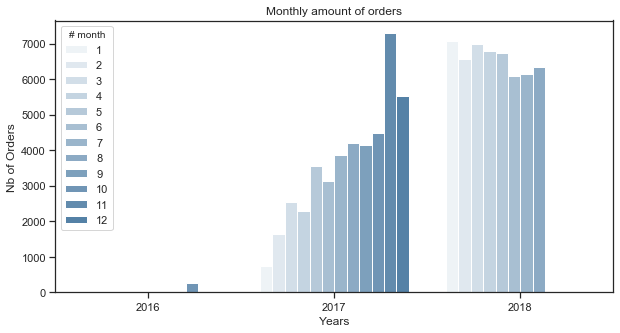

In [29]:
# afficher l'évolution des commandes
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year',
                   hue='order_purchase_month',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Years',
       ylabel='Nb of Orders',
       title='Monthly amount of orders')
plt.legend(title='# month', loc='upper left')
plt.show()

Nous disposons à compter de Janvier 2018, d'une quantité de commande stable jusqu'au mois d'Aout 2018. Les 13 mois qui précèdent montrent une augmentation monotone à l'exception d'un écart entre Novembre 2017 et Décembre 2017. <br/>
Nous pouvons envisager de construire une segmentation sur la période 2017 et tester sa stabilité en injectant un par un les 8 mois suivants. <br/>

In [30]:
df_orders.sample(7)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label
49956,349af77e71491a1aed28d6bf0528e09b,b37a5547791aeb5ac5d9ca955d0bc6fb,delivered,2017-09-30 22:59:50,2017-10-03 04:05:14,2017-10-03 21:19:05,2017-10-23 18:07:12,2017-11-09,2017,9,30,5,22,Sep,Sat
48313,37f6e52783daf8d5b0a61c8876c23b38,05d4a0e7365cf69b45d3af76236ca83a,delivered,2018-02-19 12:08:24,2018-02-19 12:27:17,2018-02-21 10:52:03,2018-03-09 12:48:28,2018-03-16,2018,2,19,0,12,Feb,Mon
49138,ed8ae7b87eac2abe38acc8471343053f,76005500a2dfa3f5d910c22cbe99f8f1,delivered,2018-04-17 21:40:37,2018-04-17 21:55:18,2018-04-18 17:28:38,2018-04-20 18:32:30,2018-05-02,2018,4,17,1,21,Apr,Tue
83598,a631b4515c67c5d6bb0555df14875938,34d3f67c077f717c79ed2894dc39fdc4,delivered,2018-07-06 18:49:36,2018-07-06 19:11:12,2018-07-09 12:47:00,2018-07-12 12:21:03,2018-08-03,2018,7,6,4,18,Jul,Fri
97916,b98e145c0cd94f225072aa0e619d5d8f,f9f966080fcd27a49a13c4d29016a309,delivered,2017-12-13 23:56:00,2017-12-15 23:51:44,2017-12-18 19:09:14,2017-12-26 18:29:42,2018-01-09,2017,12,13,2,23,Dec,Wed
72794,0c8afaedb1f20b1655f3ff0d84b4424c,0dd059e02831e97c8e5b1895a62eb290,delivered,2017-06-17 11:31:34,2017-06-17 11:45:35,2017-06-19 21:35:30,2017-07-04 16:58:38,2017-07-18,2017,6,17,5,11,Jun,Sat
21809,fea59446572d8db3b8e9709ab5c096d6,bc2b4334acd8e2111cceaa040aa39e99,delivered,2017-12-05 21:27:45,2017-12-05 21:36:22,2017-12-07 03:17:27,2017-12-20 17:49:11,2018-01-03,2017,12,5,1,21,Dec,Tue


### 4.2.2. Moment d'achat

Nous allons observer les commandes au fil des jours du mois et au fil de la semaine :<br/>
Le Client pouvant être caractérisé par le moment privilégié de la journée, de la semaine ou du mois où il effectue ses achats.<br/>

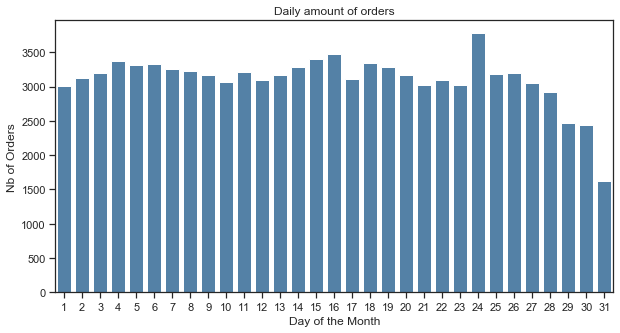

In [31]:
# afficher l'évolution des commandes selon les jours du mois (en cumul)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

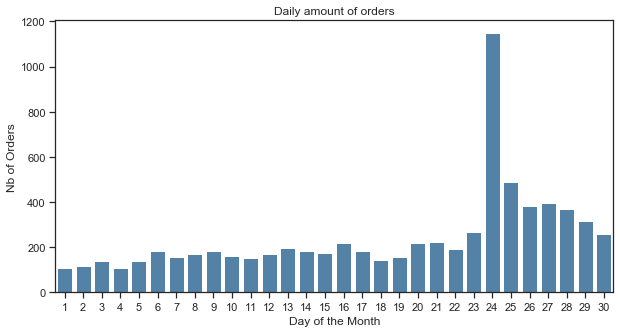

In [32]:
# afficher l'évolution des commandes selon les jours du mois (en cumul)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=df_orders[(df_orders['order_purchase_year'] == 2017) &
                                  (df_orders['order_purchase_month'] == 11)],
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

Excepté le 24 novembre 2017, nous ne constatons pas de grande variation et le plus faible nombre de commandes constatées un 31ème jour du mois est trivial.

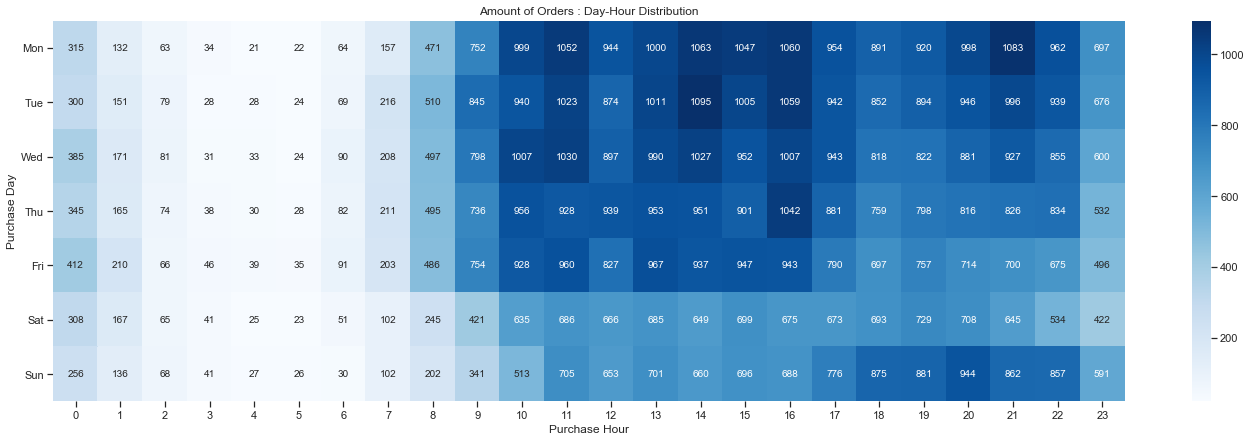

In [33]:
# afficher la répartition des commandes par heure et jour d'achat
order_count = df_orders.groupby(['order_purchase_dayofweek',
                                 'order_purchase_hour'])\
    .count()['order_id'].unstack()
plt.figure(figsize=(24, 7))
ax = sns.heatmap(order_count, cmap='Blues', annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set(xlabel='Purchase Hour',
       ylabel='Purchase Day',
       yticklabels=(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']),
       title='Amount of Orders : Day-Hour Distribution')
for item in ax.get_yticklabels():
    item.set_rotation(0)
plt.show()

Nous obtenons des périodes d'une heure pour lesquelles la quantité de commande peut varier de quelques unités à plus d'un millier (en cumul sur près de 2 ans) : nous dégageons des zones temporelles.

### 4.2.3. Découpage du moment d'achat en zone temporelles

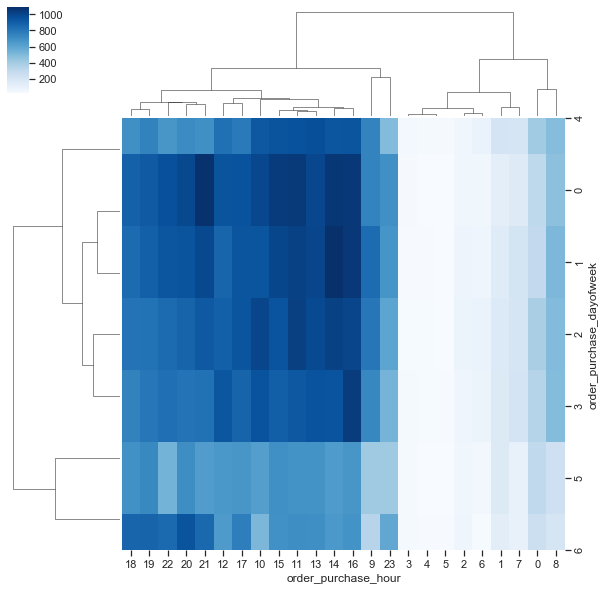

In [34]:
# afficher une clustermap pour définir les zones temporelles
sns.clustermap(order_count, cmap='Blues', method='median')
plt.show()

On confirme les zones temporelles :
- une time zone "night", creuse quelque soit le jour de la semaine, couvrant la période [0h-8h],
- une time zone "working-day", et trois sous time zones "am" [9h-12h], "pm" [13h-17h] et "evening" [18h-23h],
- une time zone "week-end", et éventuellement la sous time zone "sunday-evening". <br/>

On retient 6 time zones :
- "Night"
- "AM-WD"
- "PM-WD"
- "Evening-WD"
- "WE"
- "Evening-Sun"

In [35]:
# distinguer nuit, am, pm, evening
df_orders['time_zone_hour'] =\
    df_orders.order_purchase_hour.map({0: 'Night',
                                       1: 'Night',
                                       2: 'Night',
                                       3: 'Night',
                                       4: 'Night',
                                       5: 'Night',
                                       6: 'Night',
                                       7: 'Night',
                                       8: 'AM',
                                       9: 'AM',
                                       10: 'AM',
                                       11: 'AM',
                                       12: 'AM',
                                       13: 'PM',
                                       14: 'PM',
                                       15: 'PM',
                                       16: 'PM',
                                       17: 'PM',
                                       18: 'Evening',
                                       19: 'Evening',
                                       20: 'Evening',
                                       21: 'Evening',
                                       22: 'Evening',
                                       23: 'Evening'})

In [36]:
# distinguer week et week-end
df_orders['time_zone_day'] =\
    df_orders.order_purchase_dayofweek.map({0: 'WD',
                                            1: 'WD',
                                            2: 'WD',
                                            3: 'WD',
                                            4: 'WD',
                                            5: 'WE',
                                            6: 'WE'})

In [37]:
# construire les 3 zones DW : AM, PM et Evening
df_orders['purchase_time_zone'] = df_orders['time_zone_hour'] + '-' + df_orders['time_zone_day']

In [38]:
# construire la time zone WE
df_orders['purchase_time_zone'][df_orders['time_zone_day'] == 'WE'] = 'WE'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
# construire la time zone Night
df_orders['purchase_time_zone'][df_orders['time_zone_hour'] == 'Night'] = 'Night'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
# construire la time zone Evening-Sun
mask = (df_orders['time_zone_hour'] ==
        'Evening') & (df_orders['order_purchase_dayofweek_label'] ==
                      'Sun')
df_orders['purchase_time_zone'][mask] = 'Evening-Sun'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [41]:
df_orders['purchase_time_zone'].unique()

array(['AM-WD', 'Evening-WD', 'WE', 'Evening-Sun', 'PM-WD', 'Night'],
      dtype=object)

Text(0.5, 1.02, 'Purchase Time Zones')

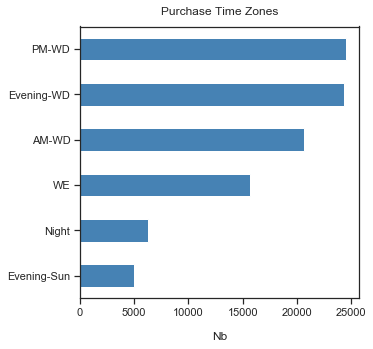

In [42]:
# observer la répartition des commandes par purchase_time_zone
df_orders['purchase_time_zone'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.title('Purchase Time Zones', y=1.02)

In [43]:
df_orders.sample(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone
11214,2b8e4a06dca9d5c4071575613d7a5037,084a0e74918bd829d509441c2504135e,delivered,2018-04-23 15:07:49,2018-04-24 19:03:45,2018-04-30 13:31:00,2018-05-04 16:38:45,2018-05-16,2018,4,23,0,15,Apr,Mon,PM,WD,PM-WD
28183,6732b3592160273b239f331a101494ff,c23b19e27fbcb26feba308d4334557fa,delivered,2018-06-03 13:33:23,2018-06-03 13:51:18,2018-06-04 11:12:00,2018-06-08 17:41:32,2018-07-11,2018,6,3,6,13,Jun,Sun,PM,WE,WE
74873,600c05aa649cdbeaaf763a60cd0a12cf,474090b9b8e1541d8ff3f614fb17398e,delivered,2017-07-19 20:19:44,2017-07-19 20:35:12,2017-07-21 20:46:37,2017-07-26 19:56:40,2017-08-03,2017,7,19,2,20,Jul,Wed,Evening,WD,Evening-WD


### 4.2.4. Retards de livraison

Le comportement futur du client peut être affecté par l'écart de date de livraison effective / estimée et dans une moindre mesure par le délai d'approbation de sa commande (ce dernier semble réduit et standard : il ne sera pas considéré à ce stade).<br/>

In [44]:
# calculer l'écart entre la livraison réelle et prévue (en jours d'avance)
df_orders['delivery_vs_estimated'] =\
    (df_orders['order_estimated_delivery_date'] -
     df_orders['order_delivered_customer_date']).dt.days

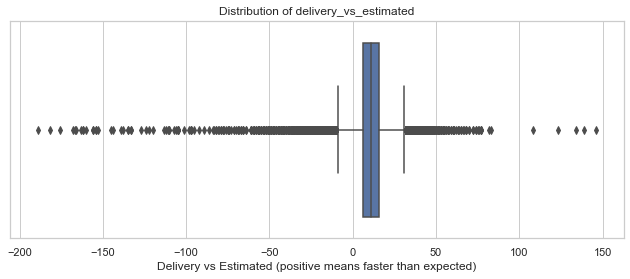

Ecart moyen entre le délai de livraison effective et estimé : 11


In [45]:
# afficher la distribution de l'écart de délai de livraison
distribution(df_orders,
             'delivery_vs_estimated',
             'Delivery vs Estimated (positive means faster than expected)')
print('Ecart moyen entre le délai de livraison effective et estimé : ' +
      str(round(df_orders['delivery_vs_estimated'].mean())))

In [46]:
# déterminer les limites pour catégoriser
cut_bins_delivery_delay = cuts(df_orders['delivery_vs_estimated'])
print(cut_bins_delivery_delay)

[-189.01, -9.01, 5.99, 16.01, 31.01, 146.01]


In [47]:
# réaliser le découpage en catégories
cut_labels_delivery_delay = ['TooLate_Delivery',
                             'Late_Delivery',
                             'OnTime_Delivery',
                             'Soon_Delivery',
                             'TooSoon_Delivery']
df_orders['delivery_vs_estimated_lvl'] = pd.cut(
    df_orders['delivery_vs_estimated'],
    bins=cut_bins_delivery_delay,
    labels=cut_labels_delivery_delay,
    duplicates='drop')

Text(0.5, 1.02, 'Delivery Delay Levels')

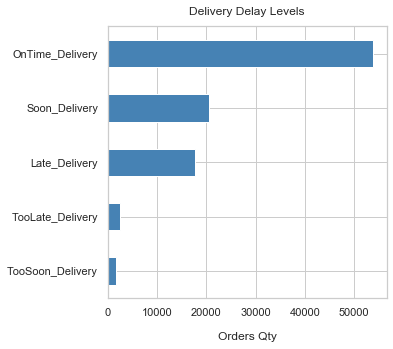

In [48]:
# observer la répartition des retard ou avance de livraison
df_orders['delivery_vs_estimated_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Delivery Delay Levels', y=1.02)

In [49]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(96455, 20)


In [50]:
# retirer l'ancienne colonne product_category_name
df_orders = df_orders.drop(
    columns=['order_status',
             'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date'])

In [51]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone,delivery_vs_estimated,delivery_vs_estimated_lvl
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017,10,2,0,10,Oct,Mon,AM,WD,AM-WD,7,OnTime_Delivery
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018,7,24,1,20,Jul,Tue,Evening,WD,Evening-WD,5,Late_Delivery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018,8,8,2,8,Aug,Wed,AM,WD,AM-WD,17,Soon_Delivery


# 5. Les articles (Items & Products)

Le dataset items relie la commande (order) aux produits (products) : il détaille le "panier" d'articles commandés, et pour lesquels sont définis le vendeur, le prix, le coût de livraison, une éventuelle date limite d'envoi.<br/>
Tandis que le dataset Products définis les caractéristiques unitaires de catégorie, taille, poids et description de l'article. <br/>
On retrouve la quantité achetée car les produits sont listés unitairement.

## 5.1. Items (articles d'un panier)

In [52]:
# aperçu des données Items
df_items.sample(7)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
41106,5da572f1c63aacf97fb438f54d622546,1,f7e0fa615b386bc9a8b9eb52bc1fff76,87142160b41353c4e5fca2360caf6f92,2017-07-27 18:02:44,98.00,9.25
37764,55b0d8973155b2b01e1849cd54bb8d89,1,fc13bac52be6640d9a77f54894e2c0e6,729b2d09b2a0bdab221076327f13d050,2018-07-12 14:30:12,28.99,18.30
96036,d9eabc69f974b3d088e991cb7a7f08cd,1,5dee2c14e1989141e15d341d4c62d72a,670c26e0f1bf8d0576271d5cfaec6d2b,2018-03-27 19:48:04,87.90,13.74
81547,b94ec498d12b1b61eabc996408439437,1,33ba4b29d820b397054cc97e892ab1bc,16090f2ca825584b5a147ab24aa30c86,2018-03-14 02:16:01,27.90,18.23
43293,6272bdc9e3d3595dd169c8e393525c7a,1,595fac2a385ac33a80bd5114aec74eb8,ef0ace09169ac090589d85746e3e036f,2018-06-26 19:00:33,118.80,9.17
342,00d1e381c0995f0bdb95909fe7434d0b,1,23227b07fc69250d2fa4be6602011aea,e38db885400cd35c71dfd162f2c1dbcf,2018-03-29 16:10:31,64.90,20.18
9239,1525ae17b338cdbe83eafba4135425d8,1,6a9678c02c9aaec51699e995ab18e48f,67883baaae6134ee81b271a542613728,2018-07-24 08:35:15,199.00,17.58


In [53]:
# ordonner les articles par prix décroissants
df_items = df_items.sort_values(by=['order_id', 'price'],
                                ascending=False)

In [54]:
# compter le nb d'articles par commande
df_items_count = df_items.groupby(
    'order_id',
    as_index=False).agg({'product_id': ['count']})
df_items_count.columns = ['order_id',
                          'items_qty']

In [55]:
# afficher les 3 commandes avec le plus d'articles
df_items_count = df_items_count.sort_values(by='items_qty',
                                            ascending=False)
df_items_count[:3]

,order_id,items_qty
50137,8272b63d03f5f79c56e9e4120aec44ef,21
10459,1b15974a0141d54e36626dca3fdc731a,20
65715,ab14fdcfbe524636d65ee38360e22ce8,20


In [56]:
# scruter les commandes avec les plus grandes quantité d'articles
df_items[df_items['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57317,8272b63d03f5f79c56e9e4120aec44ef,21,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,7.8,6.57
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


Il s'agit de quantités élevées d'un nombre réduit d'articles.

In [57]:
# moyenne du nb d'articles par commande
df_items_count['items_qty'].mean()

1.1417306873695092

In [58]:
# nombre de commandes pour lesquelles il y 2 articles ou plus
df_items_count[df_items_count['items_qty'] > 1].shape

(9803, 2)

In [59]:
# aggréger aux commandes le nb d'articles
df_orders = df_orders.merge(
    df_items_count,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [60]:
print(ref-df_orders.shape[0])
df_orders.sample(7)

2986


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty
76003,25177b0d5cfe450e1fdacf9c6b5c8f5e,9acf0054ae9afde2cb1bb937967e2a20,2018-03-31 11:11:40,2018,3,31,5,11,Mar,Sat,AM,WE,WE,13,OnTime_Delivery,1
86932,a30969bf642ba9df43445df05685de71,8a4939e95441a4310e05d7fa6cf8814c,2018-02-04 23:40:54,2018,2,4,6,23,Feb,Sun,Evening,WE,Evening-Sun,4,Late_Delivery,1
17316,3083d0620c7cc835cb4c90a8b4895eda,0eb60b1db49f6b8b063fe03c44daa664,2018-07-01 17:40:56,2018,7,1,6,17,Jul,Sun,PM,WE,WE,16,OnTime_Delivery,1
95368,001427c0ec99cf8af737bd88e92fd444,eab9c552374be06ed15923016dc9e588,2018-04-07 18:51:22,2018,4,7,5,18,Apr,Sat,Evening,WE,WE,14,OnTime_Delivery,1
36363,a60e074eb5678582482c8bc0612e591c,b081de6ac509ff7326578d9cf43f10db,2018-01-29 12:26:40,2018,1,29,0,12,Jan,Mon,AM,WD,AM-WD,9,OnTime_Delivery,1
48463,349af77e71491a1aed28d6bf0528e09b,b37a5547791aeb5ac5d9ca955d0bc6fb,2017-09-30 22:59:50,2017,9,30,5,22,Sep,Sat,Evening,WE,WE,16,OnTime_Delivery,1
54954,528bf8e17d835da2b2716f8884040e75,e2d9a04b85d3305106f1572f2b0cad37,2018-06-28 07:43:43,2018,6,28,3,7,Jun,Thu,Night,WD,Night,53,TooSoon_Delivery,1


### 5.1.1.  Article principal de la commande

Au vu de la faible récurence d'achat, l'idée est de résumer une commande à l'article le plus important, plutôt que de perdre le sens en fusionnant les caractéristiques des articles à ce stade. <br/>
On retient comme article le pus important, celui correspondant à la plus grosse dépense.

In [61]:
#  garder l'article le plus cher pour chaque commande
df_items_mip = df_items[['order_id', 'product_id']].drop_duplicates(
    subset='order_id',
    keep='first').copy()
# renommer le feature désignant le produit le plus important
df_items_mip = df_items_mip.rename(columns={'product_id': 'most_important_product'})

In [62]:
# vérifier un résultat
df_items_mip[df_items_mip['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,most_important_product
57317,8272b63d03f5f79c56e9e4120aec44ef,79ce45dbc2ea29b22b5a261bbb7b7ee7


In [63]:
# aggréger aux commandes l'article dans la plus grande quantité
df_orders = df_orders.merge(
    df_items_mip,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [64]:
# contrôler le résultat
print(ref-df_orders.shape[0])
df_orders.sample(7)

2986


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,most_important_product
75982,c95bc5d3cdd34cf9698e69308b545f48,625243048f1ccf53f22fcbf49cfc1cf7,2018-03-04 03:58:39,2018,3,4,6,3,Mar,Sun,Night,WE,Night,-16,TooLate_Delivery,1,83e5adb51c0d54eff80057f064f808d2
4513,3663c0f887191044441077fb3564dc94,da0d6b89a4173638a2b43ea9c099765b,2017-09-29 19:43:25,2017,9,29,4,19,Sep,Fri,Evening,WD,Evening-WD,17,Soon_Delivery,1,fb06535ba5dfc8f3e07fd0edc7c770fb
36414,7dbeef696a1d0ba9fb55234d2810881d,395a74da4bd6d41e8867f99a608557e3,2018-04-13 16:51:56,2018,4,13,4,16,Apr,Fri,PM,WD,PM-WD,10,OnTime_Delivery,1,1d3d7e2bc2cb75e4e2c798ec9aae0279
39600,3e049a81d7ed034671533b968ac28274,92db187ff0dc8d7522e0cc82713a1ea0,2018-02-27 14:47:00,2018,2,27,1,14,Feb,Tue,PM,WD,PM-WD,11,OnTime_Delivery,1,78018501054dd80dc909eee2f22ddbd4
35379,f62c1d95a213688bbeebb149afd3ad14,d7b642a97f26bd8fb05f71512ba0226a,2018-04-12 10:20:19,2018,4,12,3,10,Apr,Thu,AM,WD,AM-WD,15,OnTime_Delivery,1,ae7d8348fbef50928a680454fffbca00
72138,8b426ff8aa1c03dc173f1270133b408e,9840a2dfc996cade0dce0f64be44ecb8,2017-08-11 21:59:06,2017,8,11,4,21,Aug,Fri,Evening,WD,Evening-WD,12,OnTime_Delivery,2,8a33c55582d40e0d441c76c2990c467f
93393,a72fc5669df669ab2c501cd323698fac,05ad4097a892d5d8163107dd0bc3ca2d,2018-02-27 21:15:55,2018,2,27,1,21,Feb,Tue,Evening,WD,Evening-WD,-30,TooLate_Delivery,1,4328139cbe9adde0aac493ca9871eab3


Le coût de livraison semble s'ajouter pour chaque produit contrairement à ce qu'on imagine dans la réalité. <br/>

### 5.1.2. Coûts totaux et part du coût de livraison

On construit une indication de la valeur de coût de livraison par rapport au coût des produits d'une commande. <br/>

In [65]:
# scruter les commandes sans frais de livraison
df_items[df_items['freight_value'] == 0].shape

(383, 7)

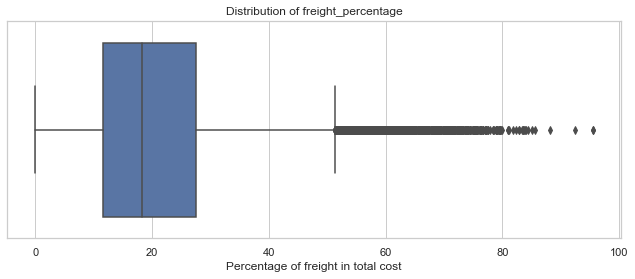

Pourcentage moyen du coût de livraison : 20


In [66]:
# calculer les coûts totaux produits et livraison
# à renommer en cart_costs
df_items_costs = df_items.groupby(
    'order_id',
    as_index=False).agg({'price': ['sum'],
                         'freight_value': ['sum']})
df_items_costs.columns = ['order_id',
                          'total_price',
                          'total_freight']
# déterminer la proportion du coût de livraison
df_items_costs['freight_percentage'] = \
    100 * df_items_costs['total_freight'] / \
    (df_items_costs['total_freight'] + df_items_costs['total_price'])
# afficher la distribution de la proportion du coût de livraison
distribution(df_items_costs,
             'freight_percentage',
             'Percentage of freight in total cost')
print('Pourcentage moyen du coût de livraison : %d'
      % df_items_costs['freight_percentage'].mean())

In [67]:
# déterminer les limites pour catégoriser
cut_bins_freight_level = cuts(df_items_costs['freight_percentage'])
print(cut_bins_freight_level)

[-0.01, -0.01, 11.640194669062593, 27.55625320472594, 51.40023916002333, 95.55507337526205]


In [68]:
# réaliser le découpage en niveau de coût de livraison
cut_labels_freight_level = ['BelowMed_FreightCost',
                            'AroundMed_FreightCost',
                            'OverMed_FreightCost',
                            'TooHigh_FreightCost']
df_items_costs['freight_percentage_lvl'] = pd.cut(
    df_items_costs['freight_percentage'],
    bins=cut_bins_freight_level,
    labels=cut_labels_freight_level,
    duplicates='drop')

Text(0.5, 1.02, 'Freight Levels')

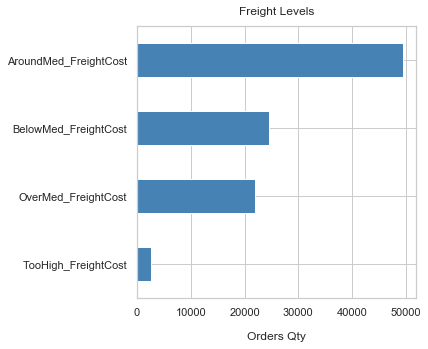

In [69]:
# observer la répartition des commandes par status
df_items_costs['freight_percentage_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Freight Levels', y=1.02)

In [70]:
# Observer les 4 features créés
df_items_costs

,order_id,total_price,total_freight,freight_percentage,freight_percentage_lvl
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,18.409752,AroundMed_FreightCost
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,7.670400,BelowMed_FreightCost
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,8.239959,BelowMed_FreightCost
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,49.612102,OverMed_FreightCost
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,8.319574,BelowMed_FreightCost
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,12.641235,AroundMed_FreightCost
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,9.450754,BelowMed_FreightCost
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,14.505777,AroundMed_FreightCost
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72,13.475506,AroundMed_FreightCost


In [71]:
# aggréger aux commandes le niveau de coût de livraison
df_orders = df_orders.merge(
    df_items_costs,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [72]:
# contrôler le résultat
print(ref-df_orders.shape[0])
df_orders.sample(3)

2986


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,time_zone_day,purchase_time_zone,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
4698,53fbedbd16ccffa3a54c400edbb3fecb,fd4abff6bfb418f4130e7d483f4ee097,2017-03-10 22:01:34,2017,3,10,4,22,Mar,Fri,...,WD,Evening-WD,9,OnTime_Delivery,1,4bb4fb9c85785b75ab4f6559900c7ca1,37.99,14.11,27.082534,AroundMed_FreightCost
38486,90a5ab921329e3765b29cef31994ee5c,379c4e1106a6441fbd8d283f0cd4a645,2018-06-25 08:44:28,2018,6,25,0,8,Jun,Mon,...,WD,AM-WD,22,Soon_Delivery,1,3fbc0ef745950c7932d5f2a446189725,66.99,27.75,29.290690,OverMed_FreightCost
89028,95eeebdd8bb3067104f4e673d2d5ea73,d28c1763c1a27adf9ade614296a59e3e,2018-01-06 18:04:35,2018,1,6,5,18,Jan,Sat,...,WE,WE,14,OnTime_Delivery,1,afa3035796721ca3ef930b1fa4c94292,93.50,17.90,16.068223,AroundMed_FreightCost


### 5.1.3.  Repérage du type de prix affiché avec terminaison "9", dit "charm price".

In [73]:
# isoler la terminaison 9 des prix affiché, dit "charm price"
# isoler les terminaisons (Centavos, Real)
df_items['last_centavos'] = df_items['price'] % 1
df_items['last_real'] = df_items['price'] % 10 - df_items['price'] % 1
# convertir en info booléen "is_charm"
df_items['charm_centavos'] =\
    df_items['last_centavos'].map(
    lambda x: 0 if x < 0.88 else 1)
df_items['charm_real'] =\
    df_items['last_real'].map(
    lambda x: 0 if x != 9 else 1)
# déterminer un booléen "charm_price" si l'une des terminaisons est "charm"
df_items['charm_price'] = df_items['charm_real'] + df_items['charm_centavos']
df_items['charm_price'] =\
    df_items['charm_price'].map(
    lambda x: 1 if x >= 1 else 0)
# retirer les colonnes obsolètes
Drop = ['last_centavos',
        'last_real',
        'charm_centavos',
        'charm_real']
df_items.drop(Drop, axis=1, inplace=True)

In [74]:
# observer le résultat
df_items.sample(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,charm_price
7721,118045506e1c1dda060171af43fe11b4,2,2c4930c4b284c7b99db2a4c52071a45e,2a261b5b644fa05f4f2700eb93544f2c,2018-03-15 19:08:26,45.00,27.08,0
100052,e2eb5d52ac1fbe44b4651b9d52b075b6,1,2b4042dfabc3fe9d3f16951a8e1a3b70,3d8fa2f5b647373c8620330c4e077a9f,2018-08-03 17:10:12,69.99,52.84,1
111918,fe451ba1809fbc234c68216803496d39,1,9e4a852f41aff52bafff133d9deb5eee,3d871de0142ce09b7081e2b9d1733cb1,2018-01-17 23:36:21,139.00,18.22,1


In [75]:
# retirer l'ancienne colonne product_category_name
df_items = df_items.drop(
    columns=['shipping_limit_date',
             'order_item_id'])

In [76]:
# réagencer les colonnes customers
df_items = df_items.rename(columns={
    'freight_value': 'product_freight',
    'price': 'product_price'})

Puisque ce dataset détaille pour chaque article, on rattachera ces données aux Produits et non aux Commandes.

## 5.2. Products

Ce dataset permet d'accéder aux caractéristiques des produits achetés.

In [77]:
# aperçu des données Products
print(df_products.shape)
df_products.head(3)

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [78]:
# retirer les valeurs manquantes et controler la taille résultante
df_products = df_products.dropna().copy()
print(df_products.shape)

(32340, 9)


In [79]:
# renommer les colonnes lenght -> length
df_products = df_products.rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'})

### 5.2.1.  Taille de l'article (volume) et densité

In [80]:
# simplifier la taille des produits (volume)
df_products['product_size'] = df_products['product_length_cm'] * \
    df_products['product_height_cm'] * df_products['product_width_cm']
# calculer la densité
df_products['product_density'] = df_products['product_weight_g'] / df_products['product_size']
# retirer le détail
df_products = df_products.drop(
    columns=['product_length_cm',
             'product_height_cm',
             'product_width_cm'])

5:80: E501 line too long (94 > 79 characters)


In [81]:
# observer les valeurs numériques
df_products.describe()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_density
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,16577.961286,0.203327
std,10.245699,635.124831,1.736787,4279.291845,27062.978147,1.017767
min,5.000000,4.000000,1.000000,0.000000,168.000000,0.000000
25%,42.000000,339.000000,1.000000,300.000000,2880.000000,0.066116
50%,51.000000,595.000000,1.000000,700.000000,6860.000000,0.115741
75%,57.000000,972.000000,3.000000,1900.000000,18522.750000,0.195312
max,76.000000,3992.000000,20.000000,40425.000000,296208.000000,85.227273


In [82]:
# compter les valeurs manquantes
df_products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_size                  0
product_density               0
dtype: int64

In [83]:
# retirer les valeurs manquantes
df_products = df_products.dropna().copy()
print(df_products.shape[0])

32340


### 5.2.2.  Catégorisation des produits par type de description : taille de description, de nom, nombre de photos

#### Product Description Length

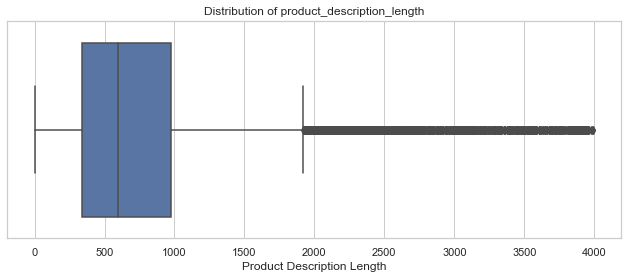

Taille moyenne de la description produit : 771


In [84]:
# observer le product_description_length
distribution(df_products,
             'product_description_length',
             'Product Description Length')
print('Taille moyenne de la description produit : %d'
      % df_products['product_description_length'].mean())

In [85]:
# définir les limites des niveaux de taille de description
cut_bins_desc_length = cuts(df_products['product_description_length'])
print(cut_bins_desc_length)

[3.99, 3.99, 338.99, 972.01, 1920.01, 3992.01]


In [86]:
# réaliser la catégorisation par taille de description
cut_labels_desc_length = ['BelowMed_DescLength',
                          'AroundMed_DescLength',
                          'OverMed_DescLength',
                          'TooHigh_DescLength']
df_products['product_desc_length_lvl'] = pd.cut(
    df_products['product_description_length'],
    bins=cut_bins_desc_length,
    labels=cut_labels_desc_length,
    duplicates='drop')

Text(0.5, 1.02, 'Product Description Length Levels')

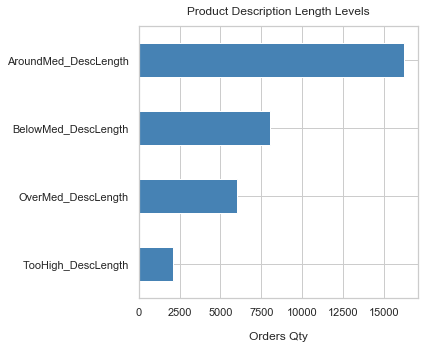

In [87]:
# observer la répartition des niveaux de taille de description
df_products['product_desc_length_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Product Description Length Levels', y=1.02)

#### Product Name Length

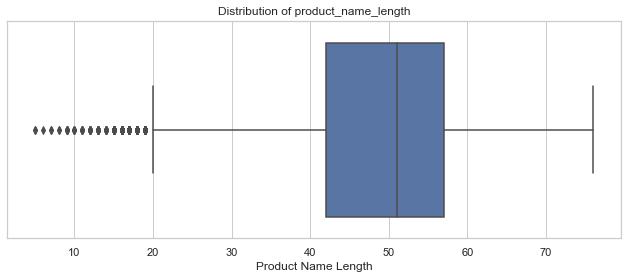

Taille moyenne nom du produit : 48


In [88]:
# observer le taille du nom de produit
distribution(df_products,
             'product_name_length',
             'Product Name Length')
print('Taille moyenne nom du produit : %d'
      % df_products['product_name_length'].mean())

In [89]:
# définir les limites des niveaux de taille de nom
cut_bins_name_length = cuts(df_products['product_name_length'])
print(cut_bins_name_length)

[4.99, 19.99, 41.99, 57.01, 76.01, 76.01]


In [90]:
# réaliser la catégorisation par taille de nom
cut_labels_name_length = ['TooShort_NameLength',
                          'BelowMed_NameLength',
                          'AroundMed_NameLength',
                          'OverMed_NameLength']
df_products['product_name_length_lvl'] = pd.cut(
    df_products['product_name_length'],
    bins=cut_bins_name_length,
    labels=cut_labels_name_length,
    duplicates='drop')

Text(0.5, 1.02, 'Product Name Length Levels')

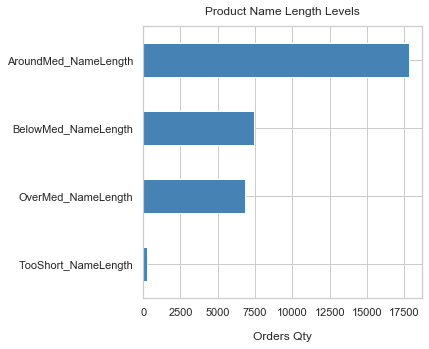

In [91]:
# observer la répartition des niveaux de taille de nome
df_products['product_name_length_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Product Name Length Levels', y=1.02)

#### Photo Quantity

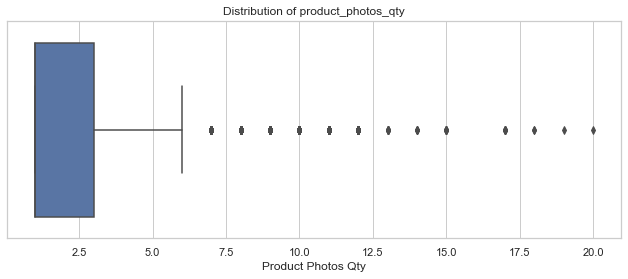

Nb moyen de photos disponibles : 2


In [92]:
# observer le product_photos_qty
distribution(df_products,
             'product_photos_qty',
             'Product Photos Qty')
print('Nb moyen de photos disponibles : %d'
      % df_products['product_photos_qty'].mean())

In [93]:
# définir les limites des niveaux de photos disponibles
cut_bins_photo_qty = cuts(df_products['product_photos_qty'])
print(cut_bins_photo_qty)

[0.99, 0.99, 0.99, 3.01, 6.01, 20.01]


In [94]:
# réaliser la catégorisation par taille de description
cut_labels_photo_qty = ['AroundMed_PhotoQty',
                        'OverMed_PhotoQty',
                        'TooHigh_PhotoQty']
df_products['product_photos_qty_lvl'] = pd.cut(
    df_products['product_photos_qty'],
    bins=cut_bins_photo_qty,
    labels=cut_labels_photo_qty,
    duplicates='drop')

Text(0.5, 1.02, 'Photos Qty Levels')

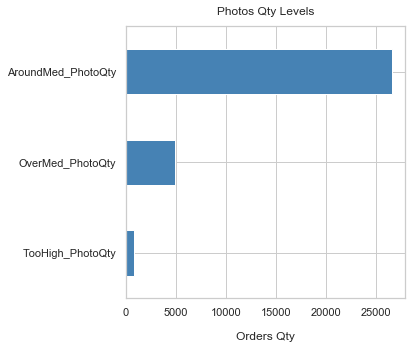

In [95]:
# observer la répartition des niveaux de taille de description
df_products['product_photos_qty_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Photos Qty Levels', y=1.02)

In [96]:
df_products['product_photos_qty_lvl'].isna().sum()

0

### 5.2.3.   Catégorisation des produits par caractéristique taille et poids

#### Taille

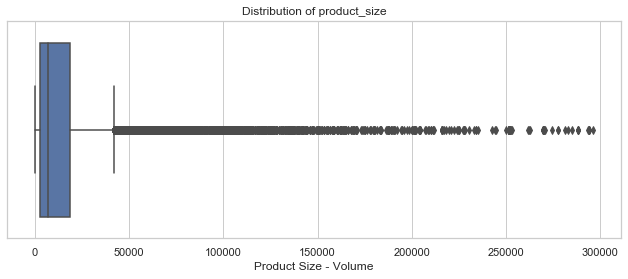

Taille moyenne des produits : 16577


In [97]:
# observer le product_size
distribution(df_products,
             'product_size',
             'Product Size - Volume')
print('Taille moyenne des produits : %d'
      % df_products['product_size'].mean())

In [98]:
# définir les limites des niveaux de photos disponibles
cut_bins_prod_size = cuts(df_products['product_size'])
print(cut_bins_prod_size)

[167.99, 167.99, 2879.99, 18522.76, 41976.01, 296208.01]


In [99]:
# réaliser la catégorisation par taille de description
cut_labels_prod_size = ['Small_Size',
                        'AroundMed_Size',
                        'Big_Size',
                        'OverLarge_Size']
df_products['product_size_lvl'] = pd.cut(
    df_products['product_size'],
    bins=cut_bins_prod_size,
    labels=cut_labels_prod_size,
    duplicates='drop')

Text(0.5, 1.02, 'Product Size Levels')

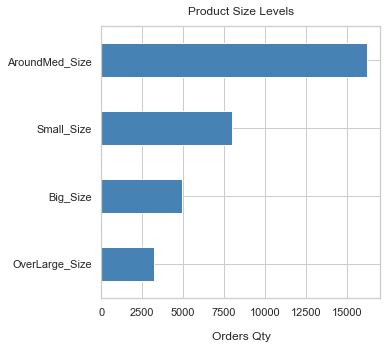

In [100]:
# observer la répartition des niveaux de taille de description
df_products['product_size_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Product Size Levels', y=1.02)

#### Poids

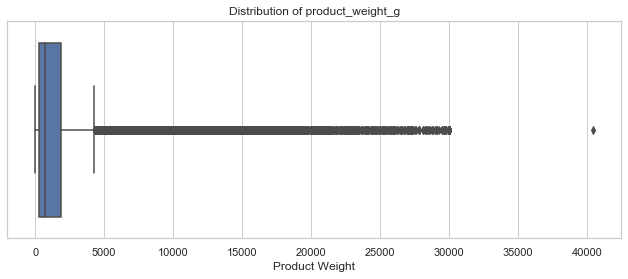

Poids moyen des produits : 2276


In [101]:
# observer le poids
distribution(df_products,
             'product_weight_g',
             'Product Weight')
print('Poids moyen des produits : %d'
      % df_products['product_weight_g'].mean())

In [102]:
# définir les limites des niveaux de photos disponibles
cut_bins_prod_weight = cuts(df_products['product_weight_g'])
print(cut_bins_prod_weight)

[-0.01, -0.01, 299.99, 1900.01, 4300.01, 40425.01]


In [103]:
# réaliser la catégorisation par taille de description
cut_labels_prod_weight = ['Light_Weight',
                          'ArounMed_Weight',
                          'Heavy_Weight',
                          'Massive_Weight']
df_products['product_weight_g_lvl'] = pd.cut(
    df_products['product_weight_g'],
    bins=cut_bins_prod_weight,
    labels=cut_labels_prod_weight,
    duplicates='drop')

Text(0.5, 1.02, 'Products Weight Levels')

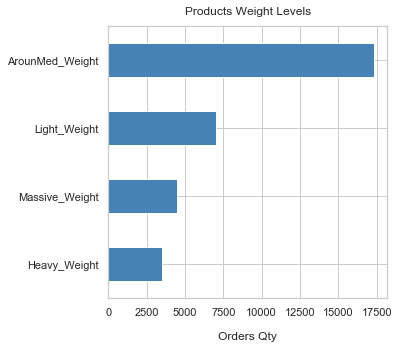

In [104]:
# observer la répartition des niveaux de taille de description
df_products['product_weight_g_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Products Weight Levels', y=1.02)

In [105]:
# contrôler le résulat
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_density,product_desc_length_lvl,product_name_length_lvl,product_photos_qty_lvl,product_size_lvl,product_weight_g_lvl
19731,3de040f7129e3e1aa3a1fd1d6c1f9f2d,papelaria,30.0,548.0,2.0,500.0,4000.0,0.125000,AroundMed_DescLength,BelowMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight
6189,4222fa433d71c969509acc408f343e89,esporte_lazer,60.0,220.0,2.0,300.0,2000.0,0.150000,BelowMed_DescLength,OverMed_NameLength,AroundMed_PhotoQty,Small_Size,ArounMed_Weight
27606,750e3a9d8289e451a68398b2c697f119,malas_acessorios,58.0,1504.0,3.0,3000.0,32190.0,0.093197,OverMed_DescLength,OverMed_NameLength,AroundMed_PhotoQty,Big_Size,Heavy_Weight


#### Densité

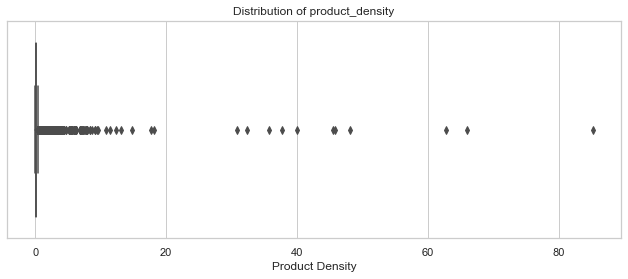

Densité moyenne des produits : 0


In [106]:
# observer la densité
distribution(df_products,
             'product_density',
             'Product Density')
print('Densité moyenne des produits : %d'
      % df_products['product_density'].mean())

In [107]:
# définir les limites des niveaux de photos disponibles
cut_bins_prod_density = cuts(df_products['product_density'])
print(cut_bins_prod_density)

[-0.01, -0.01, 0.05611570247933884, 0.2053125, 0.3988888888888889, 85.23727272727274]


In [108]:
# réaliser la catégorisation par taille de description
cut_labels_prod_density = ['Light_Density',
                           'ArounMed_Density',
                           'Heavy_Density',
                           'Massive_Density']
df_products['product_density_lvl'] = pd.cut(
    df_products['product_density'],
    bins=cut_bins_prod_density,
    labels=cut_labels_prod_density,
    duplicates='drop')

Text(0.5, 1.02, 'Products Density Levels')

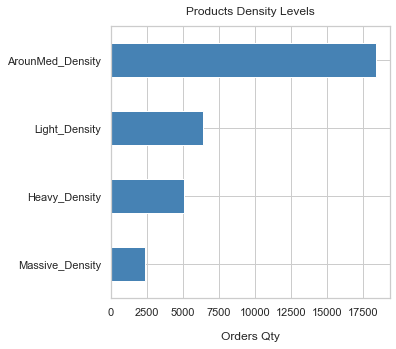

In [109]:
# observer la répartition des niveaux de taille de description
df_products['product_density_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Products Density Levels', y=1.02)

In [110]:
# contrôler le résulat
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_density,product_desc_length_lvl,product_name_length_lvl,product_photos_qty_lvl,product_size_lvl,product_weight_g_lvl,product_density_lvl
18625,f7f59e6186e10983a061ac7bdb3494d6,utilidades_domesticas,59.0,459.0,1.0,3700.0,32384.0,0.114254,AroundMed_DescLength,OverMed_NameLength,AroundMed_PhotoQty,Big_Size,Heavy_Weight,ArounMed_Density
27370,b3a397db9c6b4ddfed9d46f6fa03c65e,moveis_decoracao,56.0,2010.0,2.0,1500.0,8349.0,0.179662,TooHigh_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density
8154,729c55b4509d36c18b86f0bacc17ca5d,telefonia,58.0,702.0,6.0,250.0,864.0,0.289352,AroundMed_DescLength,OverMed_NameLength,OverMed_PhotoQty,Small_Size,Light_Weight,Heavy_Density


In [111]:
df_products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_size                  0
product_density               0
product_desc_length_lvl       0
product_name_length_lvl       0
product_photos_qty_lvl        0
product_size_lvl              0
product_weight_g_lvl          0
product_density_lvl           0
dtype: int64

#### Catégories de vente des produits

La seule indication qualitative de la nature des articles est contenue dans le nom de sa catégorie de vente. On privilégie la version anglaise pour améliorer la lisibilité.

In [112]:
# exploiter la version anglaise des catégories
df_translation.sample(3)

,product_category_name,product_category_name_english
68,fraldas_higiene,diapers_and_hygiene
4,moveis_decoracao,furniture_decor
70,seguros_e_servicos,security_and_services


In [113]:
# améliorer la lisibilité des product category
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.replace('_', ' ')
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.title()

In [114]:
# aggréger aux produits la version anglaise des catégories
df_products = df_products.merge(
    df_translation,
    how='left',
    left_on=['product_category_name'],
    right_on=['product_category_name'])
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_density,product_desc_length_lvl,product_name_length_lvl,product_photos_qty_lvl,product_size_lvl,product_weight_g_lvl,product_density_lvl,product_category_name_english
2482,0bde5c9ff4a756aed7fe09a8a3bb0dfd,pet_shop,29.0,363.0,1.0,12450.0,74520.0,0.167069,AroundMed_DescLength,BelowMed_NameLength,AroundMed_PhotoQty,OverLarge_Size,Massive_Weight,ArounMed_Density,Pet Shop
25115,98eb4ae2cc4f0aa3f5c7762583b71e51,cama_mesa_banho,56.0,1361.0,1.0,1350.0,2816.0,0.479403,OverMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,Small_Size,ArounMed_Weight,Massive_Density,Bed Bath Table
8647,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos,54.0,382.0,2.0,850.0,13860.0,0.061328,AroundMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,NaN


### 5.2.4.   Rationnalisation des catégories de produits

In [115]:
# décompter et lister les catégories
print(df_products['product_category_name_english'].unique().size)
df_products['product_category_name_english'].unique()

72


array(['Perfumery', 'Art', 'Sports Leisure', 'Baby', 'Housewares',
       'Musical Instruments', 'Cool Stuff', 'Furniture Decor',
       'Home Appliances', 'Toys', 'Bed Bath Table',
       'Construction Tools Safety', 'Computers Accessories',
       'Health Beauty', 'Luggage Accessories', 'Garden Tools',
       'Office Furniture', 'Auto', 'Electronics', 'Fashion Shoes',
       'Telephony', 'Stationery', 'Fashion Bags Accessories', 'Computers',
       'Home Construction', 'Watches Gifts',
       'Construction Tools Construction', 'Pet Shop', 'Small Appliances',
       'Agro Industry And Commerce', 'Furniture Living Room',
       'Signaling And Security', 'Air Conditioning', 'Consoles Games',
       'Books General Interest', 'Costruction Tools Tools',
       'Fashion Underwear Beach', 'Fashion Male Clothing',
       'Kitchen Dining Laundry Garden Furniture',
       'Industry Commerce And Business', 'Fixed Telephony',
       'Construction Tools Lights', 'Books Technical',
       'Home App

In [116]:
# denombrer les produits non catégorisés inconnues
df_products['product_category_name_english'].isna().sum()

13

In [117]:
df_products.isna().sum()

product_id                        0
product_category_name             0
product_name_length               0
product_description_length        0
product_photos_qty                0
product_weight_g                  0
product_size                      0
product_density                   0
product_desc_length_lvl           0
product_name_length_lvl           0
product_photos_qty_lvl            0
product_size_lvl                  0
product_weight_g_lvl              0
product_density_lvl               0
product_category_name_english    13
dtype: int64

In [118]:
df_products.describe()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_density
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,16577.961286,0.203327
std,10.245699,635.124831,1.736787,4279.291845,27062.978147,1.017767
min,5.000000,4.000000,1.000000,0.000000,168.000000,0.000000
25%,42.000000,339.000000,1.000000,300.000000,2880.000000,0.066116
50%,51.000000,595.000000,1.000000,700.000000,6860.000000,0.115741
75%,57.000000,972.000000,3.000000,1900.000000,18522.750000,0.195312
max,76.000000,3992.000000,20.000000,40425.000000,296208.000000,85.227273


#### Effectifs des produits dans chaque catégorie de vente

In [119]:
# calculer la quantité de produits dans chaque catégorie
rows = [[i, df_products[df_products['product_category_name_english'] ==
                        i].shape[0]]
        for i in df_products['product_category_name_english'].unique()]
df_category_qty = pd.DataFrame(rows, columns=['category', 'qty'])
# trier par nb de produits décroissant
df_category_qty = df_category_qty.sort_values(by='qty',
                                              ascending=False)

In [120]:
# top 5 des catégories par nb de produits
df_category_qty[:5]

,category,qty
10,Bed Bath Table,3029
2,Sports Leisure,2867
7,Furniture Decor,2657
13,Health Beauty,2444
4,Housewares,2335


In [121]:
# aggreger aux items les produits
df_items = df_items.merge(
    df_products,
    how='left',
    left_on=['product_id'],
    right_on=['product_id'])
print(df_items.shape[0])
df_items.sample(3)

112650


,order_id,product_id,seller_id,product_price,product_freight,charm_price,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_density,product_desc_length_lvl,product_name_length_lvl,product_photos_qty_lvl,product_size_lvl,product_weight_g_lvl,product_density_lvl,product_category_name_english
23094,cb5fbb27c5009572818e03f9e690edf2,41c24b8ce92d1a2cac62db5edfd088b2,4869f7a5dfa277a7dca6462dcf3b52b2,103.90,13.17,1,relogios_presentes,27.0,178.0,1.0,314.0,2772.0,0.113276,BelowMed_DescLength,BelowMed_NameLength,AroundMed_PhotoQty,Small_Size,ArounMed_Weight,ArounMed_Density,Watches Gifts
69877,61675bf97cbea18cc7bda3adfa73c348,c9c6fde711572c1ad99ca12728c6af00,562fc2f2c2863ab7e79a9e4388a58a14,29.99,18.23,1,telefonia,51.0,678.0,2.0,150.0,1904.0,0.078782,AroundMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,Small_Size,Light_Weight,ArounMed_Density,Telephony
79739,4a91ab50eb21ac9d39b0a581487fb252,fe8b0ea4a95d3a6488d8e23b41720e46,9d4db00d65d7760644ac0c14edb5fd86,199.99,19.50,1,bebes,32.0,589.0,2.0,450.0,6270.0,0.071770,AroundMed_DescLength,BelowMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,Baby


#### Quantité de produits vendus dans chaque catégorie de vente

In [122]:
# décompter les produits commandés par catégorie
df_categ_qty = df_items.groupby('product_category_name_english',
                                as_index=False).agg({'order_id': ['count']})
df_categ_qty.columns = ['product_category_name_english',
                        'count']
df_categ_qty = df_categ_qty.sort_values(by='count',
                                        ascending=False)

In [123]:
# top 5 des catégories avec le plus de produits
df_categ_qty[:5]

,product_category_name_english,count
7,Bed Bath Table,11115
43,Health Beauty,9670
65,Sports Leisure,8641
39,Furniture Decor,8334
15,Computers Accessories,7827


In [124]:
# aggreger les décompte de produits et produits commandés
df_category_qty = df_category_qty.merge(
    df_categ_qty,
    how='left',
    left_on=['category'],
    right_on=['product_category_name_english'])
df_category_qty = df_category_qty.sort_values(by='count',
                                              ascending=False)

In [125]:
# afficher les 2 quantités
pd.set_option('display.max_rows', df_category_qty.shape[0]+1)
df_category_qty

,category,qty,product_category_name_english,count
0,Bed Bath Table,3029,Bed Bath Table,11115.0
3,Health Beauty,2444,Health Beauty,9670.0
1,Sports Leisure,2867,Sports Leisure,8641.0
2,Furniture Decor,2657,Furniture Decor,8334.0
6,Computers Accessories,1639,Computers Accessories,7827.0
4,Housewares,2335,Housewares,6964.0
8,Watches Gifts,1329,Watches Gifts,5991.0
9,Telephony,1134,Telephony,4545.0
15,Garden Tools,753,Garden Tools,4347.0
5,Auto,1900,Auto,4235.0


L'ordre des quantités de produits par catégories est similaire à l'ordre des quantités de commandes effectuées dans ces catégories 

In [126]:
# rationaliser les catégories
category_mapping = {
    'Food': 'Food Drink',
    'Drinks': 'Food Drink',
    'Flowers': 'Food Drink',
    'Perfumery': 'Health Beauty',
    'Diapers And Hygiene': 'Baby',
    'Bed Bath Table': 'Home Accessories',
    'Home Confort': 'Home Accessories',
    'Home Comfort 2': 'Home Accessories',
    'La Cuisine': 'Home Accessories',
    'Housewares': 'Home Appliances',
    'Small Appliances': 'Home Appliances',
    'Home Appliances 2': 'Home Appliances',
    'Small Appliances Home Oven And Coffee': 'Home Appliances',
    'Air Conditioning': 'Home Appliances',
    'Consoles Games': 'Entertainement',
    'Art': 'Entertainement',
    'Cine Photo': 'Entertainement',
    'Books General Interest': 'Entertainement',
    'Cds Dvds Musicals': 'Entertainement',
    'Music': 'Entertainement',
    'Books Technical': 'Entertainement',
    'Audio': 'Entertainement',
    'Dvds Blu Ray': 'Entertainement',
    'Books Imported': 'Entertainement',
    'Arts And Craftmanship': 'Entertainement',
    'Musical Instruments': 'Entertainement',
    'Fashion Male Clothing': 'Fashion',
    'Fashion Sport': 'Fashion',
    'Fashion Underwear Beach': 'Fashion',
    'Fashion Bags Accessories': 'Fashion',
    'Fashio Female Clothing': 'Fashion',
    'Fashion Shoes': 'Fashion',
    'Fashion Childrens Clothes': 'Fashion',
    'Luggage Accessories': 'Fashion',
    'Kitchen Dining Laundry Garden Furniture': 'Furniture',
    'Furniture Decor': 'Furniture',
    'Office Furniture': 'Furniture',
    'Furniture Living Room': 'Furniture',
    'Furniture Bedroom': 'Furniture',
    'Furniture Mattress And Upholstery': 'Furniture',
    'Costruction Tools Tools': 'Construction & Tools',
    'Construction Tools Safety': 'Construction & Tools',
    'Garden Tools': 'Construction & Tools',
    'Construction Tools Lights': 'Construction & Tools',
    'Construction Tools Construction': 'Construction & Tools',
    'Costruction Tools Garden': 'Construction & Tools',
    'Home Construction': 'Construction & Tools',
    'Computers Accessories': 'Computers & Accessories',
    'Computers': 'Computers & Accessories',
    'Fixed Telephony': 'Telephony',
    'Tablets Printing Image': 'Computers & Accessories',
    'Agro Industry And Commerce': 'Corporate',
    'Signaling And Security': 'Corporate',
    'Security And Services': 'Corporate',
    'Industry Commerce And Business': 'Corporate',
    'Market Place': 'Corporate',
    'Stationery': 'Supplies',
    'Cool Stuff': 'Supplies',
    'Party Supplies': 'Supplies',
    'Christmas Supplies': 'Supplies'}

In [127]:
# renommer le feature des regroupement de catégories
df_category_qty = df_category_qty.rename(columns={'product_category_name_english': 'rational_category'})

In [128]:
# vérifier l'application de la correspondance
df_category_qty['rational_category'] = df_category_qty['rational_category'].replace(category_mapping)

In [129]:
# décompter les produits commandés par rational_category
df_rat_categ_qty = df_category_qty.groupby(
    'rational_category',
    as_index=False).agg({'count': ['sum']})
df_rat_categ_qty.columns = ['rational_category',
                            'new_count']
df_rat_categ_qty = df_rat_categ_qty.sort_values(by='new_count',
                                                ascending=False)

[Text(0, 0.5, 'Categories'),
 Text(0.5, 0, 'Orders Qty'),
 Text(0.5, 1.0, 'Orders by Category')]

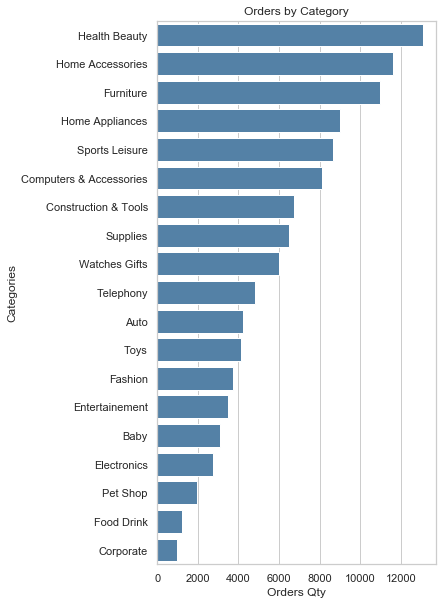

In [130]:
# contrôler la nouvelle répartition par regroupement de catégories
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='rational_category',
                 x='new_count',
                 color='Steelblue',
                 data=df_rat_categ_qty)
ax.set(xlabel='Orders Qty',
       ylabel='Categories',
       title='Orders by Category')

In [131]:
# renommer le feature des regroupement de catégories
df_items = df_items.rename(
    columns={'product_category_name_english': 'rational_category'})

# appliquer la correspondance sur le dataset des produits
df_items['rational_category'] =\
    df_items['rational_category'].replace(category_mapping)

# retirer l'ancienne colonne product_category_name
df_items = df_items.drop(
    columns=['product_category_name'])

In [132]:
df_items.sample(3)

,order_id,product_id,seller_id,product_price,product_freight,charm_price,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_density,product_desc_length_lvl,product_name_length_lvl,product_photos_qty_lvl,product_size_lvl,product_weight_g_lvl,product_density_lvl,rational_category
27314,c1e0736c3e624397f906c5371b2b381a,99444c1e11fc38755dae86f5c67d3d1a,d2374cbcbb3ca4ab1086534108cc3ab7,49.99,12.69,1,40.0,162.0,1.0,900.0,11286.0,0.079745,BelowMed_DescLength,BelowMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,Home Accessories
42555,9ff266389e4ad0e51b289d25547ce0d2,84676380ed30810651646aee76522f90,7722b1df1b0e383e000397b2c11e3e19,29.90,8.72,1,56.0,1793.0,4.0,500.0,7350.0,0.068027,OverMed_DescLength,AroundMed_NameLength,OverMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,Home Appliances
34749,b1498d9178bbadef1684ec3c4413cd31,0c79aab7a6a2449f932887fb3c8d0127,70b52a4cfc823994561b00bad161b4ed,58.50,11.02,0,43.0,420.0,3.0,250.0,2268.0,0.110229,AroundMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,Small_Size,Light_Weight,ArounMed_Density,Auto


In [133]:
df_items[df_items['product_id'] == 'ceb43e52119b25c8f2b6049a5534c339']

,order_id,product_id,seller_id,product_price,product_freight,charm_price,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_density,product_desc_length_lvl,product_name_length_lvl,product_photos_qty_lvl,product_size_lvl,product_weight_g_lvl,product_density_lvl,rational_category
21403,cf2159bbc127ae7a92a057266d687260,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,16.42,1,55.0,1392.0,1.0,750.0,4096.0,0.183105,OverMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,Sports Leisure
60975,7585d4e21b02da91dd6b9dae232f96f8,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,15.21,1,55.0,1392.0,1.0,750.0,4096.0,0.183105,OverMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,Sports Leisure
84799,3f60c18dceaa348eb8891eea71a53dc1,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,23.60,1,55.0,1392.0,1.0,750.0,4096.0,0.183105,OverMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,Sports Leisure
85688,3d5651800efaa81c9c96808ded6f145e,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,15.21,1,55.0,1392.0,1.0,750.0,4096.0,0.183105,OverMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,Sports Leisure


In [134]:
df_items.shape[0]

112650

## 5.3. Simplification au produit le plus cher d'une commande

La stratégie est d'aggréger les informations produits aux commandes sur le produit "phare" most_important_product

In [135]:
print(ref-df_orders.shape[0])
df_orders.sample(3)

2986


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,time_zone_day,purchase_time_zone,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
82033,149a156d90f9d0f82f554fba2f4a9cb0,0ea1ae45d45f7ee83bb2d6eb0c1fd03c,2017-08-15 14:31:33,2017,8,15,1,14,Aug,Tue,...,WD,PM-WD,12,OnTime_Delivery,1,fe34503c6bccf918db601aaafd4a975a,61.90,16.87,21.416783,AroundMed_FreightCost
12671,31339e08b23bc094968740000fba12f0,e3cce53d395f9c39230a95b77cee5595,2017-04-03 22:57:24,2017,4,3,0,22,Apr,Mon,...,WD,Evening-WD,20,Soon_Delivery,1,bf35317e81a1e1477a2256328bce9e9f,56.99,14.57,20.360537,AroundMed_FreightCost
94405,317e0cc749ea443d1b14522905d44dbd,c5982a46e1e7c7ae0cf888263ffbdd4f,2018-06-09 13:19:56,2018,6,9,5,13,Jun,Sat,...,WE,WE,28,Soon_Delivery,1,358d37dd53f3e05e0210a3ca3d953aca,38.90,50.85,56.657382,TooHigh_FreightCost


In [136]:
df_orders['most_important_product'].unique().size

31134

In [137]:
df_orders.shape[0]

96455

In [138]:
df_orders[df_orders['most_important_product'] == 'ceb43e52119b25c8f2b6049a5534c339']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,time_zone_day,purchase_time_zone,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
3086,cf2159bbc127ae7a92a057266d687260,79986e17c3a038cb24355365fc78a0e9,2018-04-13 07:50:12,2018,4,13,4,7,Apr,Fri,...,WD,Night,21,Soon_Delivery,1,ceb43e52119b25c8f2b6049a5534c339,64.9,16.42,20.191835,AroundMed_FreightCost
9111,3d5651800efaa81c9c96808ded6f145e,2a882786bc3a3af530ed3405b171b09b,2017-09-16 19:36:06,2017,9,16,5,19,Sep,Sat,...,WE,WE,12,OnTime_Delivery,1,ceb43e52119b25c8f2b6049a5534c339,64.9,15.21,18.986394,AroundMed_FreightCost
19261,7585d4e21b02da91dd6b9dae232f96f8,d106918f73f119d9ebf155a753135f40,2017-10-19 22:15:23,2017,10,19,3,22,Oct,Thu,...,WD,Evening-WD,13,OnTime_Delivery,1,ceb43e52119b25c8f2b6049a5534c339,64.9,15.21,18.986394,AroundMed_FreightCost
76454,3f60c18dceaa348eb8891eea71a53dc1,7b0e5d9d1949bce0504d928d8897dead,2018-08-01 20:48:00,2018,8,1,2,20,Aug,Wed,...,WD,Evening-WD,12,OnTime_Delivery,1,ceb43e52119b25c8f2b6049a5534c339,64.9,23.60,26.666667,AroundMed_FreightCost


In [139]:
df_items.shape

(112650, 19)

In [140]:
# aggréger aux commandes les informations détaillées des produits
df_orders = df_orders.merge(
    df_items,
    how='left',
    left_on=['order_id',
             'most_important_product'],
    right_on=['order_id',
              'product_id'])
print(ref-df_orders.shape[0])
df_orders.sample(3)


-6523


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,product_weight_g,product_size,product_density,product_desc_length_lvl,product_name_length_lvl,product_photos_qty_lvl,product_size_lvl,product_weight_g_lvl,product_density_lvl,rational_category
7768,ebb2b88a94eaea3dc431c26a7d21bacc,4b98719a17e513d97fe6d782d6e93f25,2017-11-24 07:56:56,2017,11,24,4,7,Nov,Fri,...,3400.0,18000.0,0.188889,AroundMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,Heavy_Weight,ArounMed_Density,Home Accessories
43408,cdbd6a9fbdb7302360e7c110ce85381f,1b957db31d28b6dc6c7a098676c03609,2017-05-20 15:15:37,2017,5,20,5,15,May,Sat,...,250.0,836.0,0.299043,AroundMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,Small_Size,Light_Weight,Heavy_Density,Telephony
17825,dce9a381febe6ed5e017df5f134a8980,79ef93ae53cf11433ff20305d4d04e2f,2018-07-25 17:54:29,2018,7,25,2,17,Jul,Wed,...,250.0,640.0,0.390625,BelowMed_DescLength,OverMed_NameLength,OverMed_PhotoQty,Small_Size,Light_Weight,Heavy_Density,Watches Gifts


In [141]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'most_important_product', 'total_price', 'total_freight',
       'freight_percentage', 'freight_percentage_lvl', 'product_id',
       'seller_id', 'product_price', 'product_freight', 'charm_price',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_size',
       'product_density', 'product_desc_length_lvl', 'product_name_length_lvl',
       'product_photos_qty_lvl', 'product_size_lvl', 'product_weight_g_lvl',
       'product_density_lvl', 'rational_category'],
      dtype='object')

# 6. Paiements

Un client peut choisir de payer à l'aide de plusieurs payment_type ce qui ouvre un payment_sequential >1. <br/> 
Il peut également choisir un étalement en n fois (valeur de payment_installments).

In [142]:
# montrer un aperçu des données de paiement
df_payments.sample(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
3329,34245c681fa744fbba46cdafcd007135,1,credit_card,2,69.33
102211,40d3d467b60d085876c572510701fc47,1,credit_card,10,116.24
76985,2f0bf599e06ae4fcb639c0acaac2f0ee,1,credit_card,3,38.32


## 6.1. Type de Paiement

In [143]:
# lister les type de paiement
df_payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

Text(0.5, 1.02, 'Payment Types')

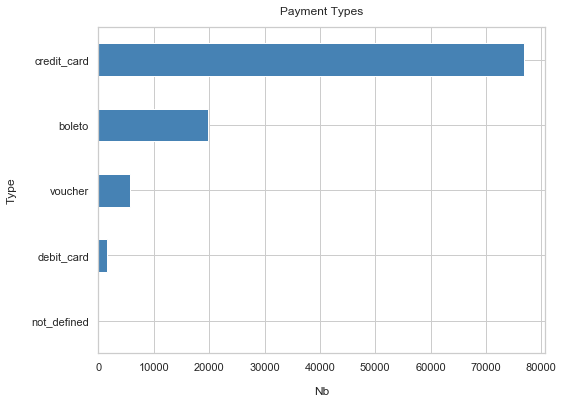

In [144]:
# observer la répartition des paiements par type
df_payments['payment_type'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('Type', labelpad=14)
plt.title('Payment Types', y=1.02)

In [145]:
# identifier les types non définis
cols = ['payment_sequential',
        'payment_type',
        'payment_installments',
        'payment_value']
mask = (df_payments['payment_type'] == 'not_defined')
print(df_payments[cols][mask].shape)
df_payments[cols][mask].sample(3)

(3, 4)


,payment_sequential,payment_type,payment_installments,payment_value
51280,1,not_defined,1,0.0
94427,1,not_defined,1,0.0
57411,1,not_defined,1,0.0


In [146]:
# retirer les paiements indéfinis
df_payments = df_payments[df_payments['payment_type'] != 'not_defined']
print(df_payments.shape)

(103883, 5)


In [147]:
# ordonner les paiements par valeur décroissante
df_payments = df_payments.sort_values(by=['order_id', 'payment_value'],
                                      ascending=False)

# retenir la taille de la séquence de paiement
df_payments_details = df_payments.groupby(
    'order_id',
    as_index=False).agg({'payment_sequential': 'max',
                         'payment_installments': 'max',
                         'payment_value': 'sum'})
df_payments_details.columns = ['order_id',
                               'payment_sequence_size',
                               'payment_installments_size',
                               'payment_total']

# aggreger les détails
df_payments = df_payments.merge(
    df_payments_details,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

# vérifier le résultat
df_payments.sample(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,payment_sequence_size,payment_installments_size,payment_total
83512,3246fdc7c13d566c0081c78d49ab6515,1,credit_card,2,44.93,1,2,44.93
21272,cba1ccee763d2eaeba1c00d3a22809a1,1,credit_card,1,67.50,1,1,67.50
70313,524dd16d182003f56199d068e2a1d50c,1,boleto,1,86.02,1,1,86.02


In [148]:
# retirer les doublons en gardant le paiement le plus important
df_payments.drop_duplicates(subset='order_id', keep='first', inplace=True)

In [149]:
# renommer les colonnes
df_payments = df_payments.rename(columns={
    'payment_type': 'main_payment_type',
    'payment_value': 'main_payment_value'})
# retirer les colonnes obsolètes
df_payments = df_payments.drop(
    columns=['payment_sequential',
             'payment_installments'])

In [150]:
# vérfieri le résultat
df_payments.sample(3)

,order_id,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total
31487,b2b7813f1cf4afc8e5728398618bbd7e,credit_card,75.17,1,2,75.17
13553,de396a46ff91b76a683f05d1f1f9b2c1,credit_card,102.37,1,5,102.37
12082,e1d7029dd87b15c8d1a60ad6aabc39ce,credit_card,135.61,1,1,135.61


In [151]:
# aggreger les détails à la commande
df_orders = df_orders.merge(
    df_payments,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

## 6.2. Ventes par catégorie de produit 

[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Category')]

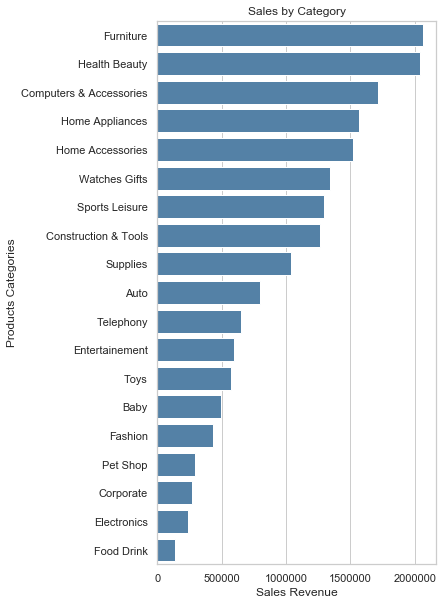

In [152]:
# répartition des ventes par catégorie de produit
df_sales_categ = df_orders.groupby(
    'rational_category',
    as_index=False).agg({'payment_total': ['sum']})
df_sales_categ.columns = ['rational_category',
                          'sales']
df_sales_categ = df_sales_categ.sort_values(by=['sales'],
                                            ascending=False)
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='rational_category',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_categ)
ax.set(xlabel='Sales Revenue',
       ylabel='Products Categories',
       title='Sales by Category')

In [153]:
weird = df_orders[(df_orders['order_purchase_year'] == 2017) &
                                  (df_orders['order_purchase_month'] == 11)]

2:35: E127 continuation line over-indented for visual indent


[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Category')]

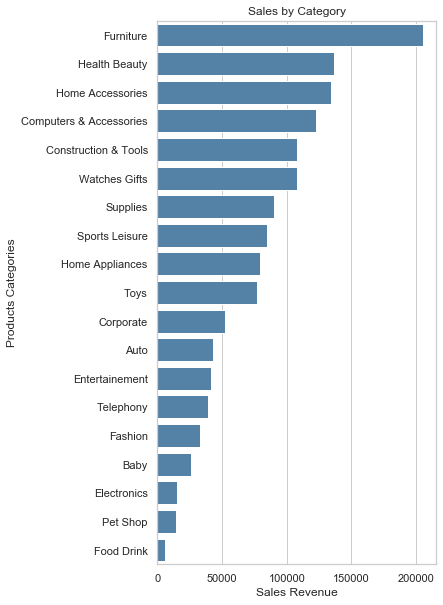

3:36: E127 continuation line over-indented for visual indent
3:80: E501 line too long (82 > 79 characters)


In [154]:
# répartition des ventes par catégories de produit
df_sales_categ = weird.groupby('rational_category',
                                   as_index=False).agg({'payment_total': ['sum']})
df_sales_categ.columns = ['rational_category',
                          'sales']
df_sales_categ = df_sales_categ.sort_values(by=['sales'],
                                            ascending=False)
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='rational_category',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_categ)
ax.set(xlabel='Sales Revenue',
       ylabel='Products Categories',
       title='Sales by Category')

Text(0.5, 1.02, 'Payment Types')

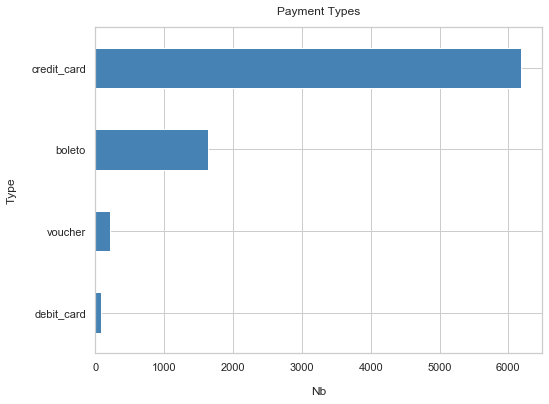

In [155]:
# observer la répartition des paiements par type
weird['main_payment_type'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('Type', labelpad=14)
plt.title('Payment Types', y=1.02)

## 6.3. Evolution mensuelle des ventes

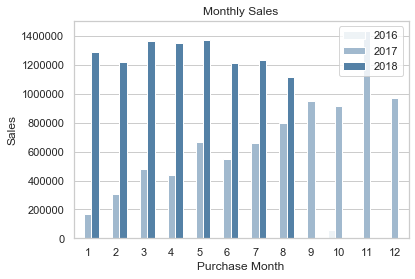

In [156]:
# évolution mensuelle des ventes
df_sales_month = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_month'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_month.columns = ['order_purchase_year',
                          'order_purchase_month',
                          'sales']
ax = sns.barplot(x='order_purchase_month',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_month)
ax.set(xlabel='Purchase Month',
       ylabel='Sales',
       title='Monthly Sales')
plt.legend(loc='upper right')

# 7. Données géographiques

Geolocation détaille toutes les paires {lat, lng}, associée à un zip_code_prefix, avec toute une diversité pour chaque {city, state}.
Pour conserver une exploitabilité et une signification marketing (zone géographiques, distances, etc.) on propose de préserver une donnée de localisation simple {lat mean, lng mean} qui sera associé à chaque ville {city, state}.

In [157]:
# aperçu des données geolocation
df_geolocation.head(7)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
6,1047,-23.546273,-46.641225,sao paulo,SP


In [158]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [159]:
# aperçu des données géographiques pour customers
df_customers.head(7)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,1
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,1
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,2
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,1


In [160]:
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

In [161]:
# aperçu des données géographiques pour sellers
df_sellers.head(7)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
5,c240c4061717ac1806ae6ee72be3533b,20920,rio de janeiro,RJ
6,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE


In [162]:
df_sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

## 7.1. Rationalisation des données géographiques

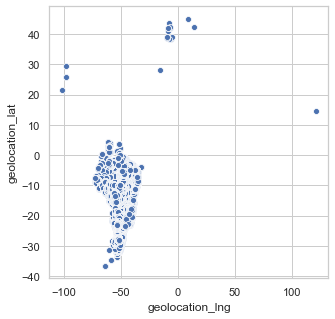

In [163]:
# afficher la répartion des localisations détaillées
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.scatterplot(x='geolocation_lng',
                     y='geolocation_lat',
                     data=df_geolocation)

In [164]:
# identifier les localisations hors Brésil
cols = ['geolocation_city',
        'geolocation_state',
        'geolocation_lat',
        'geolocation_lng']
mask = (df_geolocation['geolocation_lat'] > 10)
print(df_geolocation[cols][mask].shape)
df_geolocation[cols][mask].sample(7)

(26, 4)


,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
514429,raposo,RJ,38.381672,-6.328200
513631,vila nova de campos,RJ,41.614052,-8.411675
727755,pau d'arco,AL,45.065933,9.341528
769924,castelo dos sonhos,PA,38.713128,-9.135741
387565,bom retiro da esperanca,SP,28.008978,-15.536867
769391,porto trombetas,PA,42.167251,-6.898559
860832,ilha dos valadares,PR,42.184003,-8.723762


In [165]:
# retirer les localisations marginales
df_geolocation = df_geolocation[df_geolocation['geolocation_lat'] < 10].copy()

In [166]:
# associer des paires {lat, lng} uniques aux {city, state} uniques
# normaliser les noms de ville, et effet de la normalisation
print('geoloc cities : '
      + str(df_geolocation['geolocation_city'].unique().size))
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('geoloc cities norm : '
      + str(df_geolocation['geolocation_city'].unique().size))
print('customers cities : '
      + str(df_customers['customer_city'].unique().size))
df_customers['customer_city'] = df_customers['customer_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('customers cities norm : '
      + str(df_customers['customer_city'].unique().size))
print('sellers cities : '
      + str(df_sellers['seller_city'].unique().size))
df_sellers['seller_city'] = df_sellers['seller_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('sellers cities norm : '
      + str(df_sellers['seller_city'].unique().size))
# améliorer la lisibilité en écriture type "title"
df_customers['customer_city'] = df_customers['customer_city'].str.title()
df_sellers['seller_city'] = df_sellers['seller_city'].str.title()
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str.title()

geoloc cities : 8007
geoloc cities norm : 5965
customers cities : 4119
customers cities norm : 4119
sellers cities : 611
sellers cities norm : 609


In [167]:
# simplifier par une latitude unique {ville, état}
df_geolocation['geolocation_lat'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lat'].transform(lambda x: x.mean())

In [168]:
# simplifier par une longitude unique {ville, état}
df_geolocation['geolocation_lng'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lng'].transform(lambda x: x.mean())

In [169]:
# observer le résultat des traitements
df_geolocation.head(7)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.571253,-46.633911,Sao Paulo,SP
1,1046,-23.571253,-46.633911,Sao Paulo,SP
2,1046,-23.571253,-46.633911,Sao Paulo,SP
3,1041,-23.571253,-46.633911,Sao Paulo,SP
4,1035,-23.571253,-46.633911,Sao Paulo,SP
5,1012,-23.571253,-46.633911,Sao Paulo,SP
6,1047,-23.571253,-46.633911,Sao Paulo,SP


In [170]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [171]:
# conserver une seule localisation détaillée par {city, state}
print('geoloc with {city, state} duplicates shape : '
      + str(df_geolocation.shape))
df_geolocation = df_geolocation.drop_duplicates(['geolocation_city',
                                                 'geolocation_state']).copy()
print('geoloc unique {city, state} shape : '
      + str(df_geolocation.shape))

geoloc with {city, state} duplicates shape : (1000137, 5)
geoloc unique {city, state} shape : (6345, 5)


In [172]:
# aggréger la localisation unique pour customers et sellers
df_customers = df_customers.merge(
    df_geolocation,
    how='left',
    left_on=['customer_city', 'customer_state'],
    right_on=['geolocation_city', 'geolocation_state'])
df_sellers = df_sellers.merge(
    df_geolocation,
    how='left',
    left_on=['seller_city', 'seller_state'],
    right_on=['geolocation_city', 'geolocation_state'])

In [173]:
# observer le résultat pour customers
df_customers.sample(7)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
15028,38fa174df046c2ecf4405b469f8ff03d,3c721f9508cd151923d3c7b2c5869743,37600,Cambui,MG,1,37600.0,-22.611874,-46.058157,Cambui,MG
28797,487df359a91ee5a1c93455089b03dad5,aa96b6f45d3ed7ba77e86bf7ca9f64ae,11380,Sao Vicente,SP,1,11360.0,-23.964911,-46.393908,Sao Vicente,SP
87171,cfe0779c3ed7a15946179c36cfcea099,4a885cdb36fd6f2b3a5f73d0524a0dc8,3677,Sao Paulo,SP,1,1037.0,-23.571253,-46.633911,Sao Paulo,SP
41044,b57f3022f059774a77bd38b3b99288a6,acb9b5f1c118fb2985a9b051e92f0600,33943,Ribeirao Das Neves,MG,1,33820.0,-19.781067,-44.061294,Ribeirao Das Neves,MG
52990,b3740f9a5a2e7f17ba184a16b5754d7c,77881798e72ac342a5c253294f0dd724,12941,Atibaia,SP,1,12940.0,-23.123135,-46.560482,Atibaia,SP
90934,b51ecad2f840841fc7f24a4aca209f01,b61b38d88ef98dd66fc100efabad2557,32280,Contagem,MG,1,32041.0,-19.919039,-44.057885,Contagem,MG
14038,07171815cfd9a9aa8ee3dd62767f3ad4,c6b2ccbe75ac5addb40fcff5db96a5c1,39270,Pirapora,MG,2,39270.0,-17.340845,-44.933534,Pirapora,MG


In [174]:
# retirer les valeurs manquantes et controler la taille résultante
df_customers = df_customers.dropna().copy()
print(df_customers.shape)

(99363, 11)


In [175]:
# réagencer les colonnes customers
df_customers = df_customers.rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'})
df_customers = df_customers.drop(
    columns=['customer_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state'])

In [176]:
# réagencer les colonnes sellers (idem customers)
df_sellers = df_sellers.rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'})
df_sellers = df_sellers.drop(
    columns=['seller_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state'])

In [177]:
# observer le résultat pour sellers
df_sellers.sample(7)

,seller_id,seller_city,seller_state,seller_lat,seller_lng
2951,612a743d294c27884fb7b80d2b19ba35,Curitiba,PR,-25.453054,-49.274996
2072,8fb67a334bacec338885b4e9e1708073,Toledo,PR,-24.728850,-53.739484
1246,2156f2671501a81034d7d07f217609d0,Sp,SP,-23.610214,-46.701779
190,6d2f2e3b539480db1e0842b3a4e32e6e,Guarulhos,SP,-23.446403,-46.498768
2432,edb58a1390adf273840030a3d6253829,Piracicaba,SP,-22.725841,-47.646622
995,5b925e1d006e9476d738aa200751b73b,Sao Paulo,SP,-23.571253,-46.633911
2813,e48b04bf1aa1ef711caebeb7aede6180,Curitiba,PR,-25.453054,-49.274996


In [178]:
# retirer les valeurs manquantes et controler la taille résultante
df_sellers = df_sellers.dropna().copy()
print(df_sellers.shape)

(2996, 5)


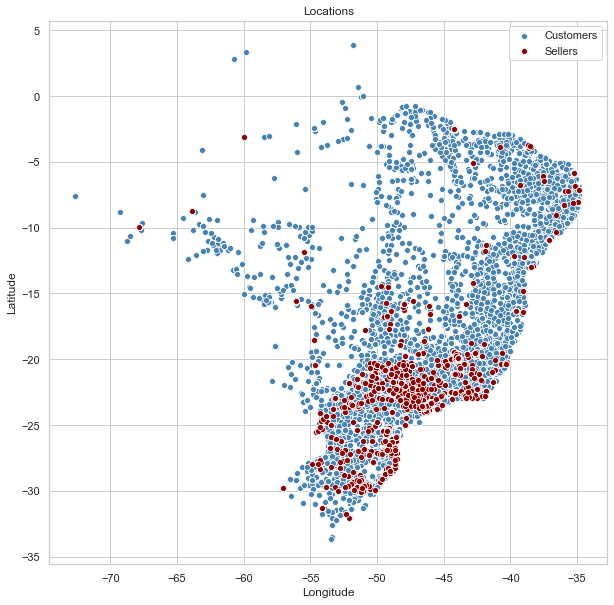

In [179]:
# affichier la nouvelle répartion (carte)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='customer_lng',
                y='customer_lat',
                color='steelblue',
                data=df_customers,
                label='Customers')
sns.scatterplot(x='seller_lng',
                y='seller_lat',
                color='darkred',
                data=df_sellers,
                label='Sellers')
plt.title('Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [180]:
# aggréger aux commandes les localisations customers et sellers
df_orders = df_orders.merge(
    df_sellers,
    how='left',
    left_on=['seller_id'],
    right_on=['seller_id'])
df_orders = df_orders.merge(
    df_customers,
    how='left',
    left_on=['customer_id'],
    right_on=['customer_id'])

In [181]:
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(102443, 54)


## 7.2. Distance Customer - Seller

Au vu de la virtualisation apportée par le e-commerce, on peut se demander si la notion distance est transparente pour les clients

In [182]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    seen on stackoverflow.com

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))



In [183]:
# calculer une distance entre customer et seller
df_orders['cust_sell_dist'] = \
    haversine(df_orders['customer_lat'],
              df_orders['customer_lng'],
              df_orders['seller_lat'],
              df_orders['seller_lng'])

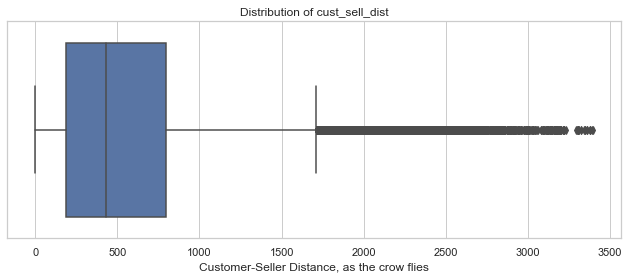

Distance moyenne entre Client et Vendeur : 598


In [184]:
# afficher la distribution de la distance sellers - customers
distribution(df_orders,
             'cust_sell_dist',
             'Customer-Seller Distance, as the crow flies')
print('Distance moyenne entre Client et Vendeur : %d'
      % df_orders['cust_sell_dist'].mean())

In [185]:
# définir les limites des niveaux de distances
cut_bins_cs_dist = cuts(df_orders['cust_sell_dist'])
print(cut_bins_cs_dist)

[-0.01, -0.01, 185.31320061701925, 796.3239216709046, 1712.5478281205499, 3396.2203944699645]


In [186]:
# réaliser la catégorisation par distance
cut_labels_cs_dist = ['Near_Dist',
                      'AroundMed_Dist',
                      'Far_Dist',
                      'VeryFar_Dist']
df_orders['cust_sell_dist_lvl'] = pd.cut(
    df_orders['cust_sell_dist'],
    bins=cut_bins_cs_dist,
    labels=cut_labels_cs_dist,
    duplicates='drop')

Text(0.5, 1.02, 'Customer-Seller Distance Levels')

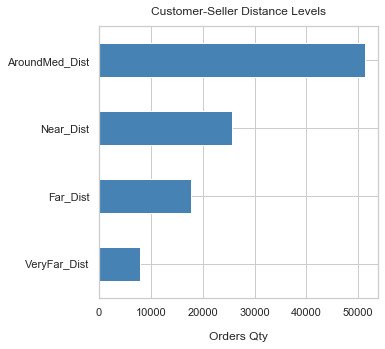

In [187]:
# observer la répartition des niveaux de distance
df_orders['cust_sell_dist_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Customer-Seller Distance Levels', y=1.02)

# 8. Review

Une review permet de remonter à la commande, mais pas au produit évalué, ce qui compromet l'exploitation détaillée.

In [188]:
# montrer un aperçu des review
df_reviews.sample(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
47963,789f072fa9495842635ad0ba856a11bd,2fdb4ded4a31592814f6865adcaf9ea7,5,NaN,NaN,2018-02-24 00:00:00,2018-02-26 10:04:11
66715,0664b1ae3f22cf3274a3af1ae6977c28,5faa7dafdf19e1e0e96dc20cff3a5f6b,1,NaN,To esperando a mochila que era para ter sido e...,2017-08-03 00:00:00,2017-08-03 17:46:20
89711,486b7d279b22a729fd77f09cb81c6418,55369224caa140402df3d45387f08c41,5,NaN,NaN,2018-03-16 00:00:00,2018-03-18 22:11:02
11780,afb63e2abeaa9c097dff895f4692c109,cd746a0e172f3aac198180760cc21a8e,4,NaN,Recomendo!! Ótimo preço!!,2017-05-18 00:00:00,2017-05-19 09:15:13
80893,f03d3279aa97bb966cb524f82b9a8e36,0822bcde10bb5d023755a71bc8f7797f,4,NaN,NaN,2018-05-16 00:00:00,2018-05-17 00:12:56


Une exploitation plus fine consisterait à valoriser la longueur du titre et du commentaire pour un aspect plus qualitatif.

## 8.1. Délai de réponse suite à une demande de review
Comportement évaluateur d'un client : délai de réponse.

In [189]:
# formater les champs date
for col in ['review_creation_date', 'review_answer_timestamp']:
    df_reviews[col] = pd.to_datetime(df_reviews[col], format='%Y-%m-%d %H:%M:%S')

In [190]:
# ordonner les reviews par valeur décroissante de dates
df_reviews = df_reviews.sort_values(by=['order_id', 'review_answer_timestamp'],
                                    ascending=False)

In [191]:
# retirer les doublons en gardant la review la plus récente
df_reviews.drop_duplicates(subset='order_id', keep='first', inplace=True)

In [192]:
# contrôler le traitement
print(df_reviews.shape[0] - df_reviews['order_id'].unique().size)

0


In [193]:
# calculer le délai de réponse (demande d'ajout d'une review)
df_reviews['review_answer_delay'] =\
    (df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']).dt.days

In [194]:
# retirer les colonnes obsolètes
df_reviews = df_reviews.drop(
    columns=['review_id',
             'review_comment_title',
             'review_comment_message',
             'review_answer_timestamp',
             'review_creation_date'])

In [195]:
# vérification du résultat
df_reviews.sample(3)

,order_id,review_score,review_answer_delay
20675,ed5c580433cad6ca57016a2c8a3f4d60,5,9
33331,cef147376bb33bb005a1402f6d1df975,4,2
73862,1bc159c29e3f54a9f2d4d2bdaa45b5df,4,0


In [196]:
# aggreger aux orders les reviews
df_orders = df_orders.merge(
    df_reviews,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

Il sera intéressant d'ajouter le délai moyen de réponse d'un client, la moyenne des notes données par un client, la moyenne des notes obtenues pour un produit pour caractériser le comportement d'achat.

## 8.2. Note moyenne donnée à chaque produit
Influence possible de la note d'un produit sur le comportement client (décompte et note moyenne)

In [197]:
# créer la note (décompte et moyenne)
df_prod_mean_score =\
    df_orders.groupby('product_id',
                      as_index=False).agg({'review_score': ['count',
                                                            'mean']})
df_prod_mean_score.columns = ['product_id',
                              'count',
                              'mean']

# afficher les 10 produits les plus notés
df_prod_mean_score = df_prod_mean_score.sort_values(by='count',
                                                    ascending=False)
df_prod_mean_score[:10]

,product_id,count,mean
20073,aca2eb7d00ea1a7b8ebd4e68314663af,520,4.036538
7865,422879e10f46682990de24d770e7f83d,470,3.968085
17919,99a4788cb24856965c36a24e339b6058,442,3.929864
6726,389d119b48cf3043d311335e499d9c6b,368,4.125000
6460,368c6c730842d78016ad823897a372db,357,4.030812
9860,53759a2ecddad2bb87a079a1f1519f73,347,3.902017
24537,d1c427060a0f73f6b889a5c7c61f2ac4,329,4.273556
9887,53b36df67ebb7c41585e8d54d6772e08,318,4.201258
7357,3dd2a17168ec895c781a9191c1e95ad7,272,4.209559
2553,154e7e31ebfa092203795c972e5804a6,268,4.361940


In [198]:
# renommer la colonne
df_prod_mean_score = df_prod_mean_score.rename(columns={
    'mean': 'product_review_mean',
    'count': 'product_review_count'})
# rattacher aux commandes la note moyenne
df_orders = df_orders.merge(
    df_prod_mean_score,
    how='left',
    left_on=['most_important_product'],
    right_on=['product_id'])

## 8.3. Note moyenne donnée par chaque client
Comportement évaluateur d'un client : décompte et note moyenne.

In [199]:
# créer la note (décompte et moyenne)
df_cust_mean_score = df_orders.groupby(
    'customer_unique_id',
    as_index=False).agg({'review_score': ['count',
                                          'mean']})
df_cust_mean_score.columns = ['customer_unique_id',
                              'count',
                              'mean']

# afficher les 10 clients donnant les meilleurs notes
df_cust_mean_score = df_cust_mean_score.sort_values(by='count',
                                                    ascending=False)
df_cust_mean_score[:10]

,customer_unique_id,count,mean
70815,c8460e4251689ba205045f3ea17884a1,24,4.0
37366,698e1cf81d01a3d389d96145f7fa6df8,20,1.0
69311,c402f431464c72e27330a67f7b94d4fb,20,1.0
5434,0f5ac8d5c31de21d2f25e24be15bbffb,18,5.0
6384,11f97da02237a49c8e783dfda6f50e8e,15,5.0
87570,f7ea4eef770a388bd5b225acfc546604,14,1.0
17659,31e412b9fb766b6794724ed17a41dfa6,14,1.0
49825,8d50f5eadf50201ccdcedfb9e2ac8455,14,5.0
41581,7582a5a77fc2976628f46a13ec91b375,13,3.0
73006,ce9f8b9c31d83341764708396ac7e38b,12,5.0


In [200]:
# rattacher au df via le customer_unique_id
df_cust_mean_score = df_cust_mean_score.rename(columns={
    'count': 'customer_review_count',
    'mean': 'customer_review_mean'})
# rattacher aux clients leur note moyenne
df_orders = df_orders.merge(
    df_cust_mean_score,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

# 9. Données consolidées et Orientation Retenue

L'EDA a révélé des features et leurs dérivés, que nous allons catégoriser pour appliquer des traitements systématiques et tester leur pertinence dans l'approche de segmentation. <br/>
A ce stade et pour aller en avant, vu les donées partielles ne permettant pas de suivi longitudinal client : on ne fera pas de "moyenne" par client, ni d'ancienneté, ni fréquence, mais on retiendra son dernier achat, et pour ce dernier achat le produit le plus cher de sa commande, en contrôlant la taille du dataset retenu.

In [201]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'most_important_product', 'total_price', 'total_freight',
       'freight_percentage', 'freight_percentage_lvl', 'product_id_x',
       'seller_id', 'product_price', 'product_freight', 'charm_price',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_size',
       'product_density', 'product_desc_length_lvl', 'product_name_length_lvl',
       'product_photos_qty_lvl', 'product_size_lvl', 'product_weight_g_lvl',
       'product_density_lvl', 'rational_category', 'main_payment_type',
       'main_payment_value', 'paym

In [202]:
# retirer les colonnes redondantes
df_orders = df_orders.drop(
    columns=['product_id_x',
             'product_id_y'])

In [203]:
# contrôler l'aggrégation sur la base des coûts
cols = ['total_price',
        'total_freight',
        'payment_total']
df_orders[cols].sample(7)

,total_price,total_freight,payment_total
30434,54.9,20.87,75.77
62862,59.9,15.17,75.07
93751,149.8,30.54,180.34
50072,45.9,9.34,55.24
44331,199.0,24.61,223.61
91180,69.9,0.00,69.90
95375,52.5,17.94,70.44


## 9.1. Simplification à la commande la plus récente

In [204]:
df_orders = df_orders.sort_values(by='order_purchase_timestamp',
                                  ascending=False)
df_orders.head(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,customer_lat,customer_lng,cust_sell_dist,cust_sell_dist_lvl,review_score,review_answer_delay,product_review_count,product_review_mean,customer_review_count,customer_review_mean
90689,35a972d7f8436f405b56e36add1a7140,898b7fee99c4e42170ab69ba59be0a8b,2018-08-29 15:00:37,2018,8,29,2,15,Aug,Wed,...,-22.573479,-47.408479,136.337204,Near_Dist,5,9,83,4.325301,1,5.0
71736,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,2018-08-29 14:52:00,2018,8,29,2,14,Aug,Wed,...,-23.626539,-46.565188,9.318239,Near_Dist,3,0,1,3.000000,1,3.0
32469,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,2018-08-29 14:18:28,2018,8,29,2,14,Aug,Wed,...,-17.231034,-46.868966,427.557967,AroundMed_Dist,5,2,29,4.172414,1,5.0


In [205]:
df_orders[df_orders['order_count'] > 1].shape[0]

6658

In [206]:
# ne garder que la dernière commande et surveiller la taille de dataset
print(df_orders.shape)
df_orders.drop_duplicates(subset='customer_unique_id',
                          keep='first',
                          inplace=True)
print(df_orders.shape)

(102443, 61)
(90360, 61)


In [207]:
df_orders[df_orders['order_count'] > 1].shape[0]

2956

In [208]:
data = df_orders.copy()

In [209]:
data.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'most_important_product', 'total_price', 'total_freight',
       'freight_percentage', 'freight_percentage_lvl', 'seller_id',
       'product_price', 'product_freight', 'charm_price',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_size',
       'product_density', 'product_desc_length_lvl', 'product_name_length_lvl',
       'product_photos_qty_lvl', 'product_size_lvl', 'product_weight_g_lvl',
       'product_density_lvl', 'rational_category', 'main_payment_type',
       'main_payment_value', 'payment_sequence_siz

In [210]:
data.columns.size

61

## 9.2. Récapitulatif et priorisation des features

In [211]:
new_index = ['customer_unique_id']

temporal_cut_features = ['order_purchase_year', 'order_purchase_month']

useless_features = ['order_id',
                    'customer_id',
                    'order_purchase_timestamp',
                    'order_purchase_month_label'
                    'order_purchase_day',
                    'order_purchase_dayofweek_label',
                    'time_zone_hour',
                    'time_zone_day',
                    'most_important_product',
                    'seller_id',
                    'seller_city',
                    'customer_city',
                    'product_review_count',
                    'review_score',
                    'seller_lat',
                    'seller_lng',
                    'customer_lat',
                    'customer_lng']

for_lvl_features = ['delivery_vs_estimated_lvl',
                    'product_desc_length_lvl',
                    'product_name_length_lvl',
                    'product_photos_qty_lvl',
                    'product_size_lvl',
                    'product_weight_g_lvl',
                    'product_density_lvl',
                    'freight_percentage_lvl',
                    'cust_sell_dist_lvl']

to_encode_features = ['rational_category',
                      'purchase_time_zone',
                      'main_payment_type',
                      'seller_state',
                      'customer_state']

In [228]:
# fonction de one-hot encoding pour les données catégorielles


def onehot(data, feature):
    # transforme en binaire les catégories
    temp_df = pd.get_dummies(data[feature])
    # préfixe le nouveau feature
    temp_df = temp_df.add_prefix(feature + '_')
    # ajoute le nouveau feature
    data = pd.concat([data, temp_df], axis=1)
    # retire le feature dans sa version d'origine
    # data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data



In [213]:
# appliquer l'encoding des variables catégorielles retenues
for i in to_encode_features:
    print(i)
    data = onehot(data, i)
    print(data.shape)

rational_category
(90360, 79)
purchase_time_zone
(90360, 84)
main_payment_type
(90360, 87)
seller_state
(90360, 107)
customer_state
(90360, 133)


In [214]:
# organiser les features catégoriels encodés
cat_feat_product = data.columns[data.columns.str.contains(
    'rational_category_')].tolist()
cat_feat_order = data.columns[data.columns.str.contains(
    'purchase_time_zone_')].tolist()
cat_feat_payment = data.columns[data.columns.str.contains(
    'main_payment_type')].tolist()
cat_feat_geoloc = data.columns[data.columns.str.contains(
    '_state_')].tolist()

In [215]:
# organiser les features numériques
num_feat_product = ['product_name_length',
                    'product_description_length',
                    'product_photos_qty',
                    'product_weight_g',
                    'product_size',
                    'product_density']
feat_product = num_feat_product + cat_feat_product
feat_item = ['product_price',
             'product_freight',
             'freight_percentage',
             'charm_price',
             'items_qty']
num_feat_payment = ['main_payment_value',
                    'payment_sequence_size',
                    'payment_installments_size',
                    'payment_total']
feat_payment = num_feat_payment + cat_feat_payment
num_feat_order = ['total_price',
                  'total_freight',
                  'order_count',
                  'order_purchase_dayofweek',
                  'order_purchase_hour',
                  'delivery_vs_estimated']
feat_order = num_feat_order + cat_feat_order
feat_review = ['product_review_count',
               'product_review_mean',
               'customer_review_count',
               'review_answer_delay',
               'customer_review_mean']
num_feat_geoloc = ['cust_sell_dist']
feat_geoloc = num_feat_geoloc + cat_feat_geoloc

In [234]:
# passer le customer_unique_id en index
data = data.rename(index=data['customer_unique_id'])

In [242]:
# fonction de transformation des features numériques


def rankgauss(data, feature):
    # crée une instance de quatiletransformer
    transformer = QuantileTransformer(n_quantiles=100,
                                      random_state=1111,
                                      output_distribution='normal')
    # adpate au feature
    transformer.fit(data[[feature]])
    # préfixe le nouveau feature
    newfeat = str('N_RG_' + feature)
    # ajoute le nouveau feature transformé
    data[newfeat] = transformer.transform(data[[feature]])
    # retire le feature dans sa version d'origine
    data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data

In [236]:
# projeter sur les feature_item
data_item = data.filter(feat_item)

In [244]:
data_item.sample(3)

,N_RG_product_price,N_RG_product_freight,N_RG_freight_percentage,N_RG_charm_price,N_RG_items_qty
a5e0c7e64371f5433e85d01dd9c2419f,0.205233,-1.548018,-1.223827,-5.199338,-5.199338
24a97b56158eb5f55b2840923c8c90d9,-0.787813,-1.150672,0.796115,-5.199338,2.166107
ede8f3660e869a9ae3b6f9c68ce47ab5,-0.126937,-0.060170,0.030318,5.199338,1.549706


In [243]:
# appliquer le rankgauss aux features bruts
for i in feat_item:
    print(i)
    data_item = rankgauss(data_item, i)
    print(data_item.shape)

product_price
(90360, 9)
product_freight
(90360, 8)
freight_percentage
(90360, 7)
charm_price
(90360, 6)
items_qty
(90360, 5)


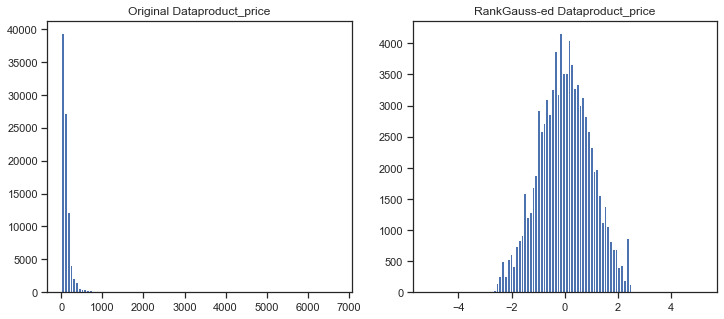

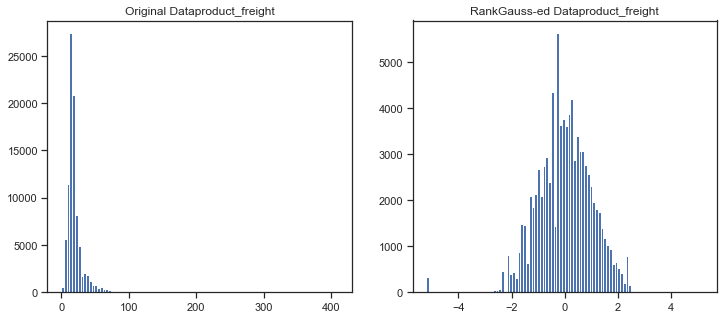

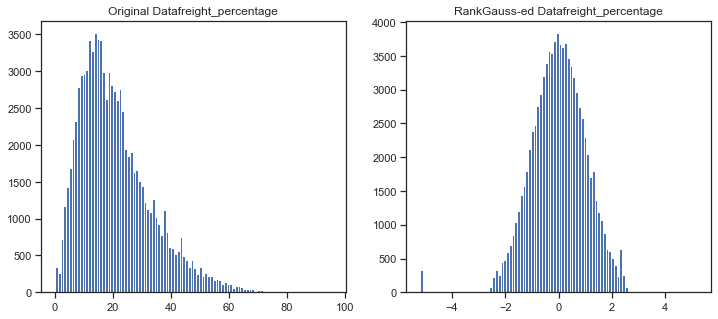

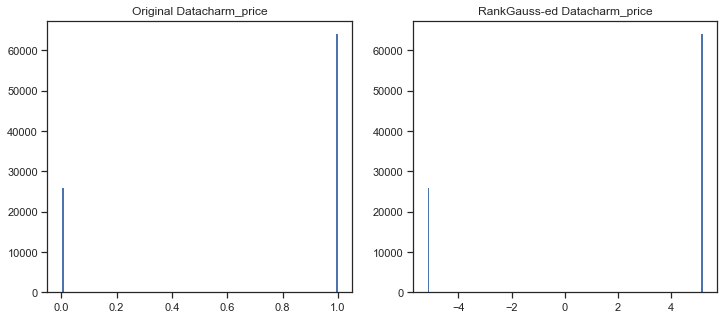

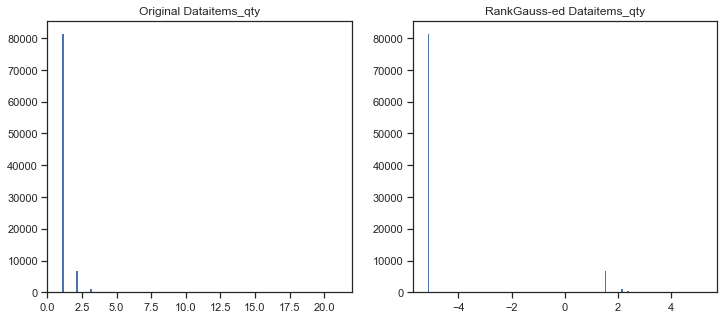

In [240]:
# observer le résultat du traitement rankgauss:
for i in feat_item:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.hist(data_item[i], bins=100)
    ax1.title.set_text(str('Original Data' + i))
    ax2.hist(data_item[str('N_RG_' + i)], bins=100)
    ax2.title.set_text(str('RankGauss-ed Data' + i))
    plt.show()

In [246]:
sse = {}
silhouette = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(data_item)
    silhouette[k] = metrics.silhouette_score(data_item, kmeans.labels_)
    sse[k] = kmeans.inertia_

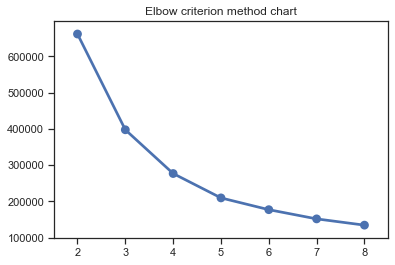

In [247]:
plt.title('Elbow criterion method chart')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

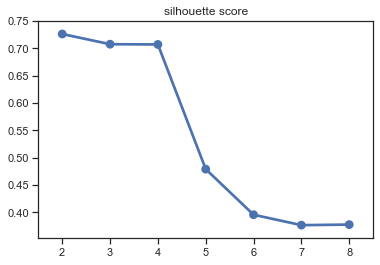

In [248]:
plt.title('silhouette score')
sns.pointplot(x=list(silhouette.keys()), y=list(silhouette.values()))

In [249]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit_predict(data_item)

array([1, 1, 1, ..., 1, 0, 1])

In [250]:
metrics.davies_bouldin_score(data_item, kmeans.labels_)

0.4485120971297308

In [ ]:
feat_review

In [ ]:
# projection sur les données Avis
data_review = data.filter(feat_review)
data_review.shape

In [ ]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_review.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

On choisit de conserver les deux moyennes de notes données.

In [ ]:
num_feat_product

In [ ]:
# projection sur les données product
data_product = data.filter(num_feat_product)
data_product.shape

In [ ]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_product.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

On choisit de conserver la taille et le poids

In [ ]:
feat_order

In [ ]:
# projection sur les données order
data_order = data.filter(feat_order)
data_order.shape

In [ ]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_order.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
feat_item

In [ ]:
# projection sur les données order
data_item = data.filter(feat_item)
data_item.shape

In [ ]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_item.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

on ne priorise pas item_qty, il est surprenant de constater que le freight pourcentage n'est plus corrélé avec le cout de livraison (mais reste corrélé négativement au prix du produit)

In [ ]:
num_feat_geoloc

In [ ]:
# projection sur les données order
data_geoloc = data.filter(num_feat_geoloc)
data_geoloc.shape

In [ ]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_geoloc.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

on conserve ces features

In [ ]:
feat_payment

In [ ]:
# projection sur les données order
data_payment = data.filter(feat_payment)
data_payment.shape

In [ ]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_payment.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

on choisit de conserver le total, le nombre de versement, le type.

# selection des features

In [ ]:
feature_selection = ['payment_installments_size',
                     'payment_total',
                     'main_payment_type_boleto',
                     'main_payment_type_credit_card',
                     'main_payment_type_debit_card',
                     'main_payment_type_voucher',
                     'freight_percentage',
                     'charm_price',
                     'total_freight',
                     'purchase_time_zone_AM-WD',
                     'purchase_time_zone_Evening-Sun',
                     'purchase_time_zone_Evening-WD',
                     'purchase_time_zone_Night',
                     'purchase_time_zone_PM-WD',
                     'purchase_time_zone_WE',
                     'product_review_mean',
                     'customer_review_mean']

In [ ]:
# projection sur les données
data_selection = data.filter(feature_selection)
data_selection.shape

In [ ]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_selection.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
feature_to_export = feature_selection + cat_feat_product + for_lvl_features + temporal_cut_features

In [ ]:
# projection sur les données
data_export = data.filter(feature_to_export)
data_export.shape

In [ ]:
# exporter les données
data_export.to_csv('Data/data.csv', index=False)

In [ ]:
data.columns

In [ ]:
data.shape